# First integration of heat flex through additional stores -- testing it out 

author: Katherine Shaw
date: July 23 

In [2]:
#Packages 
import pypsa
import matplotlib.pyplot as plt 
import cartopy 
import geopandas
import networkx
import linopy
import cartopy.crs as ccrs
import atlite 
import geopandas as gpd 
import xarray
import pandas as pd 
from datetime import datetime
import numpy as np
from pypsa.plot import add_legend_patches
import random
import plotly.graph_objects as go

## Overall view of colors matched to carriers 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

#importing auxillary functions
import Auxillary_Functions as af

In [7]:
def bus_connections(network, bus_name): 
    if bus_name in network.buses.index.values:

        connected_generators = network.generators[network.generators.bus == bus_name]
        connected_loads = network.loads[network.loads.bus == bus_name]
        connected_storage_units = network.storage_units[network.storage_units.bus == bus_name]
        connected_links_in = network.links[network.links.bus1 == bus_name]
        connected_links_out = network.links[network.links.bus0 == bus_name]
        connected_lines = network.lines[(network.lines.bus0 == bus_name) | (network.lines.bus1 == bus_name)]
        connected_transformers = network.transformers[(network.transformers.bus0 == bus_name) | (network.transformers.bus1 == bus_name)]
        connected_stores = network.stores[network.stores.bus == bus_name]
        if any(connected_generators.index.values):
            print("The generators connected to this bus are:    " + str(connected_generators.index.values))
        if any(connected_loads.index.values):
            print("The loads connected to this bus are:     " + str(connected_loads.index.values))
        if any(connected_storage_units.index.values):
            print("The storage units connected to this bus are:   " + str(connected_storage_units.index.values))
        if any(connected_stores.index.values):
            print("The stores connected to this bus are:   " + str(connected_stores.index.values))
        if any(connected_links_in.index.values):
            print("The incoming links to this bus are from the bus:  " +  str(connected_links_in.bus0.values))
        if any(connected_links_in.index.values):
            print("The incoming links are:  " +  str(connected_links_in.index))
        if any(connected_links_out.index.values):
            print("The outgoing links from this bus are to the bus:  " +  str(connected_links_out.bus1.values))
        if any(connected_lines.index.values):
            print("The lines connected to this bus are connected to:   "  + str(connected_lines.bus1.values))
        if any(connected_transformers.index.values):
            print(connected_transformers.index.values)
        return None    
    else:      
        return str("This bus does not exist in the network")

In [21]:
Heatflex_2020_1 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
Heatflex_2030_1 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
Heatflex_2040_1 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
Heatflex_2050_1 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


<Axes: xlabel='snapshot'>

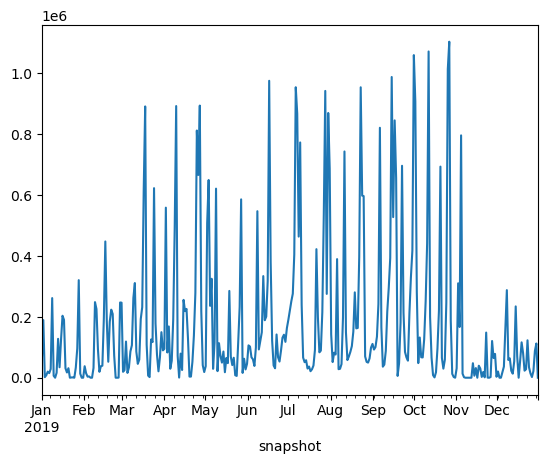

In [36]:
network = Heatflex_2040_1
network.stores.carrier.unique()
urban_decentral_water_tanks = network.stores[network.stores.carrier == 'urban decentral water tanks']
storage_tanks = urban_decentral_water_tanks[urban_decentral_water_tanks.index.str.contains('storage', case = False, na = False)]
storage_tanks_names = storage_tanks.index
storage_tanks_soc = network.stores_t.e[storage_tanks_names].sum(axis =1)
storage_tanks_soc.plot()

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_75139/2728252352.py:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<Axes: xlabel='snapshot'>

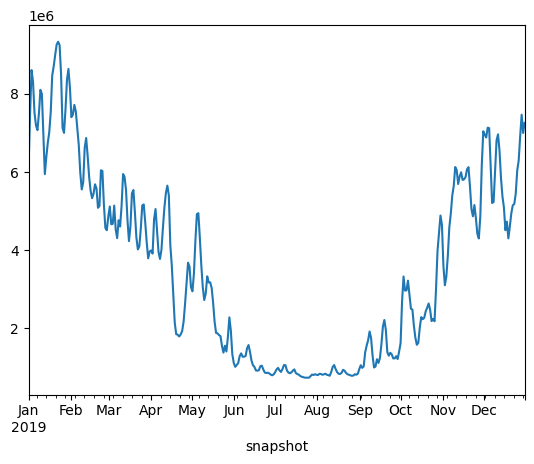

In [51]:
#Does this contribute to the load to the heat bus 
heat_buses = storage_tanks.bus.unique()
heat_loads = network.loads[network.loads.bus.isin(heat_buses)]
urban_decentral_heat_buses = network.links[network.links.bus0.isin(heat_buses)].bus1.unique()
urban_decentral_heat_loads_names = network.loads[network.loads.bus.isin(urban_decentral_heat_buses)].index
yearly_urban_decenral_heat_loads = network.loads_t.p[urban_decentral_heat_loads_names].sum(axis=1) #this is in MW 
(yearly_urban_decenral_heat_loads * network.snapshot_weightings.objective[0]).plot()

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_75139/282686428.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<Axes: xlabel='snapshot'>

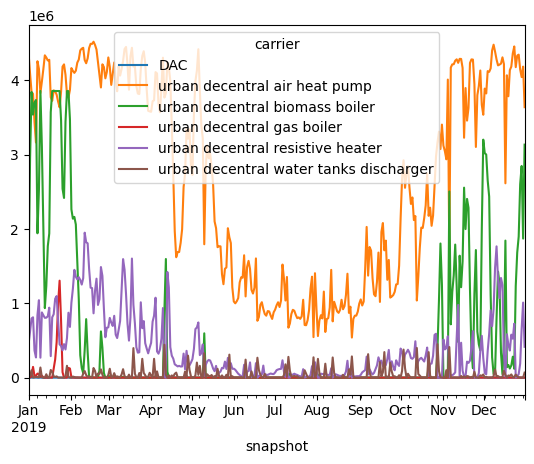

In [75]:
#All heat links
network = Heatflex_2040_1
urban_decentral_heat_buses = network.links[network.links.bus0.isin(heat_buses)].bus1.unique()
links_into_heat_bus = network.links[network.links.bus1.isin(urban_decentral_heat_buses)].index
power_heat_links = network.links_t.p1[links_into_heat_bus] * -1
power_heat_links = power_heat_links * network.snapshot_weightings.objective[0] #now in MWh #need to group by carrier 
carrier_grouped_power_heat_links = power_heat_links.T.groupby(network.links[network.links.bus1.isin(urban_decentral_heat_buses)].carrier).sum()
#YES the water tanks discharger is operating at the same time the heat pump would have 
carrier_grouped_power_heat_links.T.plot()

In [73]:
carrier_grouped_power_heat_links.sum(axis=1)

carrier
DAC                                      -3.762261e+05
urban decentral air heat pump             6.255467e+08
urban decentral biomass boiler            3.582042e+07
urban decentral gas boiler                9.534576e+00
urban decentral resistive heater          6.506265e+07
urban decentral water tanks discharger    8.854517e+06
dtype: float64

In [ ]:
#need to matchperiods of high heat pump and periods of high charger

In [104]:
#This one has much more capcity in the additional storage tanks -- does it do anything? 
Heatflex_2020_2 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results_additional_heat_flex_with_dac/networks/base_s_39___2020.nc')
Heatflex_2030_2 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results_additional_heat_flex_with_dac/networks/base_s_39___2030.nc')
Heatflex_2040_2 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results_additional_heat_flex_with_dac/networks/base_s_39___2040.nc')
Heatflex_2050_2 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results_additional_heat_flex_with_dac/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Text(0, 0.5, 'Heat Link Dispatch [MWh]')

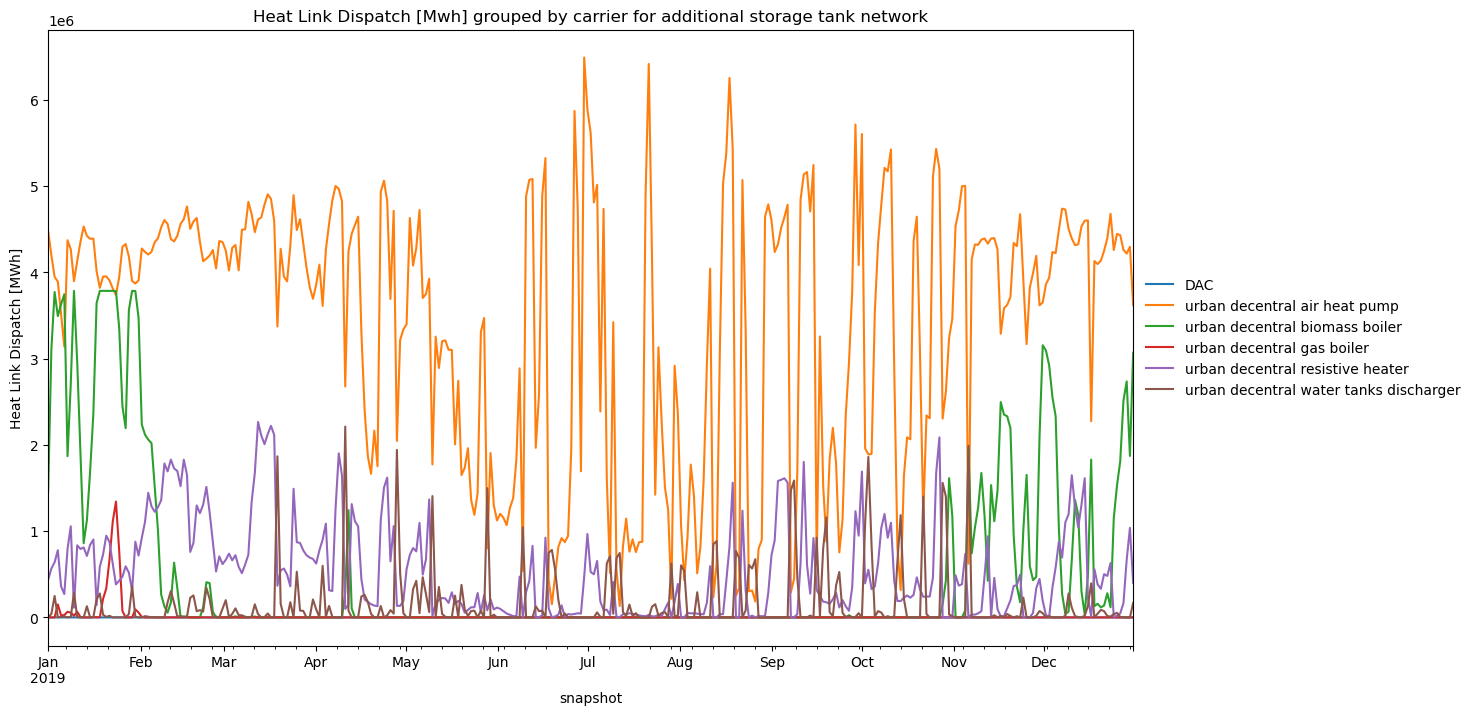

In [117]:
#All heat links
network = Heatflex_2040_2
urban_decentral_heat_buses = network.links[network.links.bus0.isin(heat_buses)].bus1.unique()
links_into_heat_bus = network.links[network.links.bus1.isin(urban_decentral_heat_buses)].index
power_heat_links = network.links_t.p1[links_into_heat_bus] * -1
power_heat_links = power_heat_links * network.snapshot_weightings.objective[0] #now in MWh #need to group by carrier 
carrier_grouped_power_heat_links2 = power_heat_links.T.groupby(network.links[network.links.bus1.isin(urban_decentral_heat_buses)].carrier).sum()
#YES the water tanks discharger is operating at the same time the heat pump would have 
fig, ax = plt.subplots(figsize=(14, 8))  # Enlarged figure size
carrier_grouped_power_heat_links2.T.plot(ax=ax)

# Move the legend outside
plt.title('Heat Link Dispatch [Mwh] grouped by carrier for additional storage tank network')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.ylabel('Heat Link Dispatch [MWh]')


In [106]:
carrier_grouped_power_heat_links2.sum(axis=1)

carrier
DAC                                      -3.558214e+05
urban decentral air heat pump             1.152547e+09
urban decentral biomass boiler            1.726579e+08
urban decentral gas boiler                5.096795e+06
urban decentral resistive heater          1.820404e+08
urban decentral water tanks discharger    5.650620e+07
dtype: float64

In [ ]:
heat_comparison_dataframe = pd.DataFrame(carrier_grouped_power_heat_links.sum(axis=1))
heat_comparison_dataframe['additional storage tanks'] = carrier_grouped_power_heat_links2.sum(axis=1) 
heat_comparison_dataframe['additional heat storage network - standard network'] = - heat_comparison_dataframe[0] + heat_comparison_dataframe['additional storage tanks']
heat_comparison_dataframe
#it's using more of everything? 

0  \
carrier                                                
DAC                                    -4.310302e+05   
urban decentral air heat pump           9.146132e+08   
urban decentral biomass boiler          1.798414e+08   
urban decentral gas boiler              4.601356e+06   
urban decentral resistive heater        1.326030e+08   
urban decentral water tanks discharger  1.400492e+07   

                                        additional storage tanks  \
carrier                                                            
DAC                                                -3.558214e+05   
urban decentral air heat pump                       1.152547e+09   
urban decentral biomass boiler                      1.726579e+08   
urban decentral gas boiler                          5.096795e+06   
urban decentral resistive heater                    1.820404e+08   
urban decentral water tanks discharger              5.650620e+07   

                                        additional heat storage network - standard network  
carrier                                                                                     
DAC                                                                          7.520881e+04   
urban decentral air heat pump                                                2.379341e+08   
urban decentral biomass boiler                                              -7.183450e+06   
urban decentral gas boiler                                                   4.954399e+05   
urban decentral resistive heater                                             4.943740e+07   
urban decentral water tanks discharger                                       4.250128e+07

conventional  geothermal    8.562331e+05
              nuclear       3.197160e+08
              CCGT          4.749359e+00
              OCGT          8.103588e-01
              coal          4.084555e-01
              lignite       4.099799e-01
dtype: float64
renewable  offwind-ac       9.167972e+08
           offwind-dc       1.247334e+09
           offwind-float    4.732457e+08
           onwind           1.976010e+09
           ror              1.543695e+08
           solar            2.695364e+09
           solar rooftop    1.005633e+09
           solar-hsat       2.308062e+08
dtype: float64
conventional  geothermal    8.560941e+05
              nuclear       3.492940e+08
              CCGT          1.697777e+01
              OCGT          2.726517e+00
              coal          1.496245e+00
              lignite       1.421169e+00
dtype: float64
renewable  offwind-ac       8.969515e+08
           offwind-dc       1.268295e+09
           offwind-float    4.350743e+08
           o

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:379: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:390: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/pypsa-eur/Evaluation Documents/Auxillary_Functions.py:379: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/katherine.shaw/Desktop/p

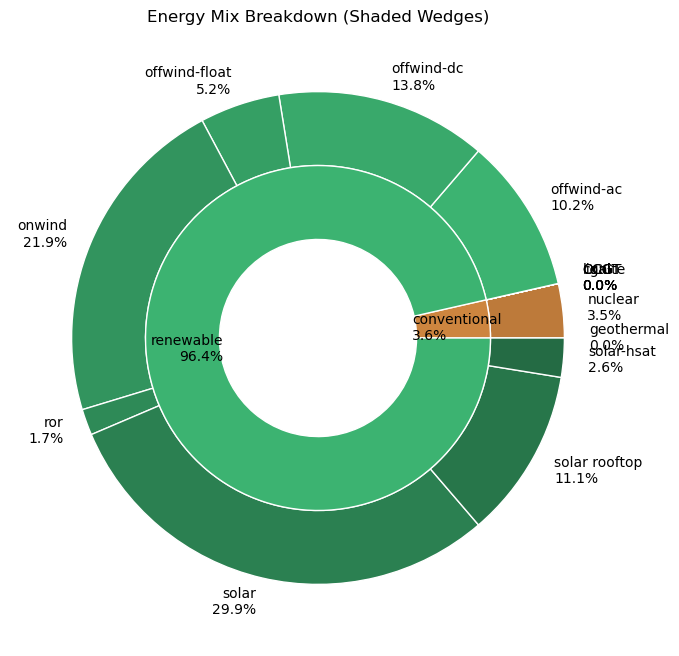

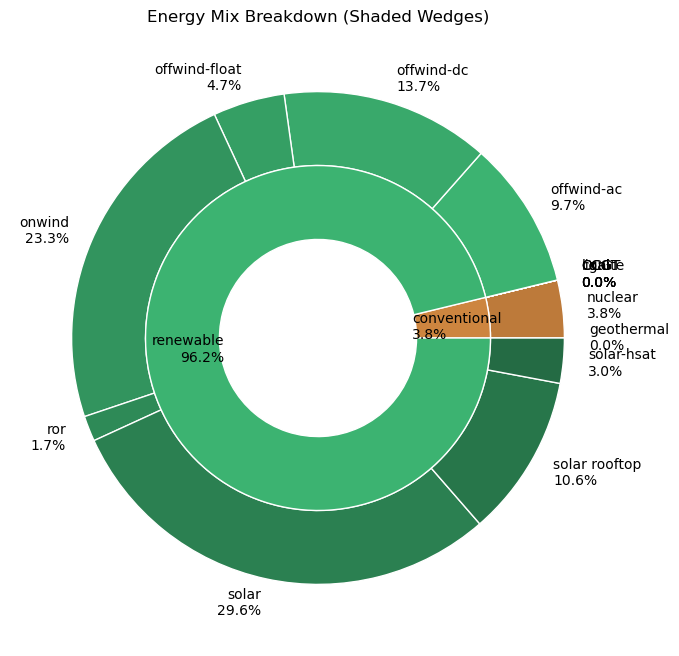

In [91]:
#the heat pump was used more, but so was every other type of heater except biomass (no reduction in gas)
af.carrier_pie_chart(Heatflex_2040_1)
af.carrier_pie_chart(Heatflex_2040_2)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
less_flex_scenarios = [Heatflex_2020_1, Heatflex_2030_1, Heatflex_2040_1, Heatflex_2050_1]
moreflex_flex_scenarios = [Heatflex_2020_2, Heatflex_2030_2, Heatflex_2040_2, Heatflex_2050_2]
carbon_budget = pd.DataFrame(np.zeros(4))
carbon_budget['less_flex'] = np.zeros(4)
carbon_budget['more flex'] = np.zeros(4)
for index_value, net in enumerate(less_flex_scenarios):
    carbon_budget['less_flex'][index_value] = net.stores_t.e['co2 atmosphere'][-1]
carbon_budget
for index_value, net in enumerate(moreflex_flex_scenarios):
    carbon_budget['more flex'][index_value] = net.stores_t.e['co2 atmosphere'][-1]
carbon_budget
#carbon budgets abided by


0     less_flex     more flex
0  0.0  3.314820e+09  3.314820e+09
1  0.0  2.071763e+09  2.071763e+09
2  0.0  4.603917e+08  4.603917e+08
3  0.0  2.230018e+08  2.258405e+08

In [ ]:
#what about with no dac? 


bus0                        bus1 type  \
Link                                                                     
AL0 0 urban central DAC-2040    AL0 0    AL0 0 urban central heat        
AT0 0 urban central DAC-2040    AT0 0    AT0 0 urban central heat        
BA0 0 urban central DAC-2040    BA0 0    BA0 0 urban central heat        
BE0 0 urban central DAC-2040    BE0 0    BE0 0 urban central heat        
BG0 0 urban central DAC-2040    BG0 0    BG0 0 urban central heat        
...                               ...                         ...  ...   
RS0 0 urban decentral DAC-2040  RS0 0  RS0 0 urban decentral heat        
SE1 0 urban decentral DAC-2040  SE1 0  SE1 0 urban decentral heat        
SI0 0 urban decentral DAC-2040  SI0 0  SI0 0 urban decentral heat        
SK0 0 urban decentral DAC-2040  SK0 0  SK0 0 urban decentral heat        
XK0 0 urban decentral DAC-2040  XK0 0  XK0 0 urban decentral heat        

                               carrier  efficiency  active  build_year  \
Link                                                                     
AL0 0 urban central DAC-2040       DAC   -2.545455    True        2040   
AT0 0 urban central DAC-2040       DAC   -2.545455    True        2040   
BA0 0 urban central DAC-2040       DAC   -2.545455    True        2040   
BE0 0 urban central DAC-2040       DAC   -2.545455    True        2040   
BG0 0 urban central DAC-2040       DAC   -2.545455    True        2040   
...                                ...         ...     ...         ...   
RS0 0 urban decentral DAC-2040     DAC   -2.545455    True        2040   
SE1 0 urban decentral DAC-2040     DAC   -2.545455    True        2040   
SI0 0 urban decentral DAC-2040     DAC   -2.545455    True        2040   
SK0 0 urban decentral DAC-2040     DAC   -2.545455    True        2040   
XK0 0 urban decentral DAC-2040     DAC   -2.545455    True        2040   

                                lifetime  p_nom  p_nom_mod  ...  reversed  \
Link                                                        ...             
AL0 0 urban central DAC-2040        20.0    0.0        0.0  ...     False   
AT0 0 urban central DAC-2040        20.0    0.0        0.0  ...     False   
BA0 0 urban central DAC-2040        20.0    0.0        0.0  ...     False   
BE0 0 urban central DAC-2040        20.0    0.0        0.0  ...     False   
BG0 0 urban central DAC-2040        20.0    0.0        0.0  ...     False   
...                                  ...    ...        ...  ...       ...   
RS0 0 urban decentral DAC-2040      20.0    0.0        0.0  ...     False   
SE1 0 urban decentral DAC-2040      20.0    0.0        0.0  ...     False   
SI0 0 urban decentral DAC-2040      20.0    0.0        0.0  ...     False   
SK0 0 urban decentral DAC-2040      20.0    0.0        0.0  ...     False   
XK0 0 urban decentral DAC-2040      20.0    0.0        0.0  ...     False   

                                project_status  geometry  underwater_fraction  \
Link                                                                            
AL0 0 urban central DAC-2040                                              NaN   
AT0 0 urban central DAC-2040                                              NaN   
BA0 0 urban central DAC-2040                                              NaN   
BE0 0 urban central DAC-2040                                              NaN   
BG0 0 urban central DAC-2040                                              NaN   
...                                        ...       ...                  ...   
RS0 0 urban decentral DAC-2040                                            NaN   
SE1 0 urban decentral DAC-2040                                            NaN   
SI0 0 urban decentral DAC-2040                                            NaN   
SK0 0 urban decentral DAC-2040                                            NaN   
XK0 0 urban decentral DAC-2040                                            NaN   

                                dc  voltage  under_

In [100]:
#This one has much more capcity in the additional storage tanks -- does it do anything? 
Heatflex_2020_no_dac = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
Heatflex_2030_no_dac = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
Heatflex_2040_no_dac = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
Heatflex_2050_no_dac = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')



INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


<Axes: xlabel='snapshot'>

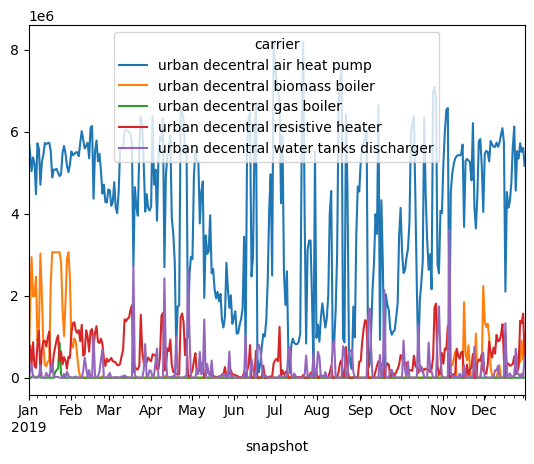

In [102]:
#All heat links
network = Heatflex_2040_no_dac
urban_decentral_heat_buses = network.links[network.links.bus0.isin(heat_buses)].bus1.unique()
links_into_heat_bus = network.links[network.links.bus1.isin(urban_decentral_heat_buses)].index
power_heat_links = network.links_t.p1[links_into_heat_bus] * -1
power_heat_links = power_heat_links * network.snapshot_weightings.objective[0] #now in MWh #need to group by carrier 
carrier_grouped_power_heat_links_no_dac = power_heat_links.T.groupby(network.links[network.links.bus1.isin(urban_decentral_heat_buses)].carrier).sum()
#YES the water tanks discharger is operating at the same time the heat pump would have 
carrier_grouped_power_heat_links_no_dac.T.plot()

In [113]:
heat_comparison_dataframe = pd.DataFrame(carrier_grouped_power_heat_links.sum(axis=1))
heat_comparison_dataframe['additional storage tanks'] = carrier_grouped_power_heat_links2.sum(axis=1) 
heat_comparison_dataframe['additional heat storage network - standard network'] = - heat_comparison_dataframe[0] + heat_comparison_dataframe['additional storage tanks']

heat_comparison_dataframe['additional storage plus no dac'] = carrier_grouped_power_heat_links_no_dac.sum(axis=1)
heat_comparison_dataframe['no dac storage - standard storage '] = - heat_comparison_dataframe[0] + heat_comparison_dataframe['additional storage plus no dac']
heat_comparison_dataframe['additional storage w/ dac - additional storage w/o dac'] = heat_comparison_dataframe['additional storage tanks'] - heat_comparison_dataframe['additional storage plus no dac']
heat_comparison_dataframe

0  \
carrier                                                
DAC                                    -4.310302e+05   
urban decentral air heat pump           9.146132e+08   
urban decentral biomass boiler          1.798414e+08   
urban decentral gas boiler              4.601356e+06   
urban decentral resistive heater        1.326030e+08   
urban decentral water tanks discharger  1.400492e+07   

                                        additional storage tanks  \
carrier                                                            
DAC                                                -3.558214e+05   
urban decentral air heat pump                       1.152547e+09   
urban decentral biomass boiler                      1.726579e+08   
urban decentral gas boiler                          5.096795e+06   
urban decentral resistive heater                    1.820404e+08   
urban decentral water tanks discharger              5.650620e+07   

                                        additional heat storage network - standard network  \
carrier                                                                                      
DAC                                                                          7.520881e+04    
urban decentral air heat pump                                                2.379341e+08    
urban decentral biomass boiler                                              -7.183450e+06    
urban decentral gas boiler                                                   4.954399e+05    
urban decentral resistive heater                                             4.943740e+07    
urban decentral water tanks discharger                                       4.250128e+07    

                                        additional storage plus no dac  \
carrier                                                                  
DAC                                                                NaN   
urban decentral air heat pump                             1.355194e+09   
urban decentral biomass boiler                            8.188519e+07   
urban decentral gas boiler                                1.664217e+06   
urban decentral resistive heater                          1.361543e+08   
urban decentral water tanks discharger                    6.285980e+07   

                                        no dac storage - standard storage   \
carrier                                                                      
DAC                                                                    NaN   
urban decentral air heat pump                                 4.405805e+08   
urban decentral biomass boiler                               -9.795618e+07   
urban decentral gas boiler                                   -2.937139e+06   
urban decentral resistive heater                              3.551326e+06   
urban decentral water tanks discharger                        4.885488e+07   

                                        additional storage w/ dac - additional storage w/o dac  
carrier                                                                                         
DAC                                                                                   NaN       
urban decentral air heat pump                                               -2.026463e+08       
urban decentral biomass boiler                                               9.077273e+07       
urban decentral gas boiler                                                   3.432579e+06       
urban decentral resistive heater                                             4.588607e+07       
urban decentral water tanks discharger                                      -6.353605e+06

In [195]:
dac_base_option = -4.310302e+05	 + 9.146132e+08	 + 1.798414e+08 + 4.601356e+06	+ 1.326030e+08	+ 1.400492e+07	

In [196]:
dac_additional_storage_option = -3.558214e+05	 + 1.152547e+09	 + 1.726579e+08	+ 5.096795e+06	+ 1.820404e+08	+ 5.650620e+07	

In [197]:
dac_additional_storage_option -dac_base_option

323259627.79999995

In [198]:
total_left

12.101249590977908

In [ ]:
#need to know how much went INTO the storage tanks in the additional storage tanks network 
#then compare to what went out 
#difference == total loss 
#is the difference in generation from the additional storage tank network equal to the loss from the tanks
#and therefore the extra generation is not unreasonable? 
#or is it just additional generation that goes elsewhere? 
network = Heatflex_2040_2 
network.stores.carrier.unique() #just going to look at urban decentral, though should probably look at all
tank_index = network.stores[network.stores.carrier == 'urban decentral water tanks'].bus
tank_index
charger_list = network.links[network.links.bus1.isin(tank_index)].index
total_in = (network.links_t.p1[charger_list].sum().sum() * -1 * network.snapshot_weightings.objective[0]) #this is the total amount of energy that went into the storage tanks in MWh

total_left = network.stores_t.e[(network.stores[network.stores.carrier == 'urban decentral water tanks'].index)]
total_left = total_left.iloc[-1].sum()
#total_left = total_left * network.snapshot_weightings.objective[0] #already in MWh
total_left

12.101249590977908

In [191]:
#trying to calculate standing loss 
#network.stores_t.e[network.stores[network.stores.carrier == 'urban decentral water tanks'].index].plot()
#this is a plot of the fill, 
stored_water_Mwh = network.stores_t.e[network.stores[network.stores.carrier == 'urban decentral water tanks'].index]
stored_water_Mwh #does this include the standing loss or not? 
#ugh that's really confusing, it must be included then? 
total_in - total_left

331355998.16135365

In [ ]:
Heatflex_2040_no_dac

# August 4, 
## Comparing Heat flex scenarios

In [250]:
#new reference scenario with dac but with no additional storage tanks 
no_heatflex_no_dac_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
no_heatflex_no_dac_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
no_heatflex_no_dac_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
no_heatflex_no_dac_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')



INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [253]:
heat_comparison_dataframe['no heat flex no dac'] = np.zeros(6)
heat_comparison_dataframe = heat_comparison_dataframe[[0, 'no heat flex no dac']] #, 'additional storage tanks', 'additional heat storage network - standard network', 'additional storage plus no dac', 'no dac storage - standard storage ', 'additional storage w/ dac - additional storage w/o dac']]

#All heat links
network = no_heatflex_no_dac_2040
urban_decentral_heat_buses = network.links[network.links.bus0.isin(heat_buses)].bus1.unique()
links_into_heat_bus = network.links[network.links.bus1.isin(urban_decentral_heat_buses)].index
power_heat_links = (network.links_t.p1[links_into_heat_bus] * -1).copy()
power_heat_links = power_heat_links * network.snapshot_weightings.objective[0] #now in MWh #need to group by carrier 
carrier_grouped_power_heat_links2 = power_heat_links.T.groupby(network.links[network.links.bus1.isin(urban_decentral_heat_buses)].carrier).sum()
carrier_grouped_power_heat_links2 = carrier_grouped_power_heat_links2.sum(axis=1) #MWh from heat items over the course of the year 

heat_comparison_dataframe['no heat flex no dac'] = carrier_grouped_power_heat_links2
heat_comparison_dataframe

heat_comparison_dataframe['additional storage plus no dac'] = carrier_grouped_power_heat_links_no_dac.sum(axis=1)
heat_comparison_dataframe

0  no heat flex no dac  \
carrier                                                                     
DAC                                    -4.310302e+05                  NaN   
urban decentral air heat pump           9.146132e+08         9.676009e+08   
urban decentral biomass boiler          1.798414e+08         1.281748e+08   
urban decentral gas boiler              4.601356e+06         2.633098e+07   
urban decentral resistive heater        1.326030e+08         7.822201e+07   
urban decentral water tanks discharger  1.400492e+07         3.941442e+04   

                                        additional storage plus no dac  
carrier                                                                 
DAC                                                                NaN  
urban decentral air heat pump                             1.355194e+09  
urban decentral biomass boiler                            8.188519e+07  
urban decentral gas boiler                                1.664217e+06  
urban decentral resistive heater                          1.361543e+08  
urban decentral water tanks discharger                    6.285980e+07

In [ ]:
#Questions

#What was happening with heat 

# 

In [ ]:
f"{heat_comparison_dataframe[0].sum():.2e}"

'1.25e+09'

In [ ]:

f"{heat_comparison_dataframe['additional storage tanks'].sum():.2e}"

'1.57e+09'

In [ ]:
f"{heat_comparison_dataframe['additional storage plus no dac'].sum():.2e}"

'1.64e+09'

In [ ]:
#taking dac out of the picture got it to follow our intuition more re storage options, but then we have to change everything else.

Answer 1: the difference between the naught and additional storage system is not due to the standing loss 

Question 1: Explicitly what are the changes between a dac and no dac system, regarding the additional storage 

Q1.1: In a system with direct air capture, does the additional storage lead to a behavior that we understand

Question 2: How does the dac change the system, comparing the two base cases (dac and no dac), and comparing the additional storage cases (additional with dac and additional without dac)?


#to asnwer question 1 
#the dac system 

With additional storage tanks, 
we have MORE heat pump, 
more gas boiler,
more resistive heating, 
more tank discharger, 
and less biomass boiler. 


the total amount of heat generated is different between the additional storage and less storage systems, 
that difference is not due to the standing loss of the remaining heat in the storage tansk at the end of the model year (about 5mwh for the naught scenario, 12 mwh for the additional storage senario)




In [259]:
#the no dac system 
no_dac_comparison_dataframe = pd.DataFrame()
relevant_networks = [no_heatflex_no_dac_2040, Heatflex_2040_no_dac]
relevant_network_names = ['no heat flex no dac', 'heat flex no dac']

for i, net in enumerate(relevant_networks):
    network = net
    relevant_buses = ['urban decentral heat' , 'rural heat'] 
    relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
    relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index
    relevant_links = network.links_t.p1[relevant_links] 
    relevant_links = relevant_links * -network.snapshot_weightings.objective[0] #now in MWh
    relevant_links = relevant_links.T.groupby(network.links.carrier).sum() 
    relevant_links = relevant_links.sum(axis=1)
    no_dac_comparison_dataframe[relevant_network_names[i]] = relevant_links 

no_dac_comparison_dataframe

no heat flex no dac  heat flex no dac
carrier                                                                      
rural air heat pump                            2.342792e+02      3.847837e+02
rural biomass boiler                           7.127579e+06      6.110759e+06
rural gas boiler                               9.170300e+06      1.255716e+06
rural ground heat pump                         7.735683e+08      1.102650e+09
rural resistive heater                         1.653346e+07      1.643889e+07
rural water tanks discharger                   4.331367e+04      4.313904e+07
urban decentral air heat pump                  9.676009e+08      1.355194e+09
urban decentral biomass boiler                 1.281748e+08      8.188519e+07
urban decentral gas boiler                     2.633098e+07      1.664217e+06
urban decentral resistive heater               7.822201e+07      1.361543e+08
urban decentral water tanks discharger         3.941442e+04      6.285980e+07

In [260]:
no_dac_comparison_dataframe.loc['SUM'] = no_dac_comparison_dataframe.sum()
no_dac_comparison_dataframe['with storage, more or less?'] = (no_dac_comparison_dataframe['no heat flex no dac'] < no_dac_comparison_dataframe['heat flex no dac'])#true if more, false if less
no_dac_comparison_dataframe

no heat flex no dac  heat flex no dac  \
carrier                                                                         
rural air heat pump                            2.342792e+02      3.847837e+02   
rural biomass boiler                           7.127579e+06      6.110759e+06   
rural gas boiler                               9.170300e+06      1.255716e+06   
rural ground heat pump                         7.735683e+08      1.102650e+09   
rural resistive heater                         1.653346e+07      1.643889e+07   
rural water tanks discharger                   4.331367e+04      4.313904e+07   
urban decentral air heat pump                  9.676009e+08      1.355194e+09   
urban decentral biomass boiler                 1.281748e+08      8.188519e+07   
urban decentral gas boiler                     2.633098e+07      1.664217e+06   
urban decentral resistive heater               7.822201e+07      1.361543e+08   
urban decentral water tanks discharger         3.941442e+04      6.285980e+07   
SUM                                            2.006811e+09      2.807352e+09   

                                        with storage, more or less?  
carrier                                                              
rural air heat pump                                            True  
rural biomass boiler                                          False  
rural gas boiler                                              False  
rural ground heat pump                                         True  
rural resistive heater                                        False  
rural water tanks discharger                                   True  
urban decentral air heat pump                                  True  
urban decentral biomass boiler                                False  
urban decentral gas boiler                                    False  
urban decentral resistive heater                               True  
urban decentral water tanks discharger                         True  
SUM                                                            True

WITH NO dac, heat flex still has the heating links delivering more heat to the heat buses in total 



In [228]:
#the dac system (revised to be comparable here)
dac_comparison_dataframe = pd.DataFrame()
relevant_networks = [Heatflex_2040_1, Heatflex_2040_2]
relevant_network_names = ['no heat flex dac', 'heat flex dac']

for i, net in enumerate(relevant_networks):
    network = net
    relevant_buses = ['urban decentral heat' , 'rural heat'] 
    relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
    relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index
    relevant_links = network.links_t.p1[relevant_links] 
    relevant_links = relevant_links * -network.snapshot_weightings.objective[0] #now in MWh
    relevant_links = relevant_links.T.groupby(network.links.carrier).sum() 
    relevant_links = relevant_links.sum(axis=1)
    dac_comparison_dataframe[relevant_network_names[i]] = relevant_links 

dac_comparison_dataframe
dac_comparison_dataframe.loc['SUM'] = dac_comparison_dataframe.sum()
dac_comparison_dataframe['with storage, more or less?'] = (dac_comparison_dataframe['no heat flex dac'] < dac_comparison_dataframe['heat flex dac'])#true if more, false if less
dac_comparison_dataframe

no heat flex dac  heat flex dac  \
carrier                                                                   
DAC                                        -4.310302e+05  -3.558214e+05   
rural air heat pump                         1.853663e+02   4.933083e+02   
rural biomass boiler                        1.360925e+07   1.173336e+07   
rural gas boiler                            2.914034e+06   2.886465e+06   
rural ground heat pump                      8.140540e+08   1.010566e+09   
rural resistive heater                      1.189312e+07   2.163928e+07   
rural water tanks discharger                1.410709e+07   4.183073e+07   
urban decentral air heat pump               9.146132e+08   1.152547e+09   
urban decentral biomass boiler              1.798414e+08   1.726579e+08   
urban decentral gas boiler                  4.601356e+06   5.096795e+06   
urban decentral resistive heater            1.326030e+08   1.820404e+08   
urban decentral water tanks discharger      1.400492e+07   5.650620e+07   
SUM                                         2.101810e+09   2.657149e+09   

                                        with storage, more or less?  
carrier                                                              
DAC                                                            True  
rural air heat pump                                            True  
rural biomass boiler                                          False  
rural gas boiler                                              False  
rural ground heat pump                                         True  
rural resistive heater                                         True  
rural water tanks discharger                                   True  
urban decentral air heat pump                                  True  
urban decentral biomass boiler                                False  
urban decentral gas boiler                                     True  
urban decentral resistive heater                               True  
urban decentral water tanks discharger                         True  
SUM                                                            True

OK the difference seems to be that when there is dac, the operation of the urban decentral gas boiler goes up with addtional flex
In the no dac case, the urban decentral gas boiler goes down
(also a slight change in the resistive heater, but that could be a rounding error/optimization fluke)



In [263]:
Total_difference_in_dac_dataframe = pd.DataFrame()
#no heat flex, heat flex #total MWh 
no_dac = [2.006811e+09,	2.807352e+09	]
dac = [2.101810e+09,	2.657149e+09	]

Total_difference_in_dac_dataframe['no heat flex'] = np.zeros(2)
Total_difference_in_dac_dataframe['heat flex'] = np.zeros(2)
Total_difference_in_dac_dataframe.loc['no dac'] = no_dac
Total_difference_in_dac_dataframe.loc['dac'] = dac 
Total_difference_in_dac_dataframe  = Total_difference_in_dac_dataframe.iloc[2:]
Total_difference_in_dac_dataframe


no heat flex     heat flex
no dac  2.006811e+09  2.807352e+09
dac     2.101810e+09  2.657149e+09

dac is increasing total heat generated when there's no heat flex, decreases when there is heat flex. With dac and no dac, heat flex seems to add total generation into the heat bus 



In [ ]:
#repeating this for 2030 and 2055

#2030 

In [249]:
no_dac_comparison_dataframe = pd.DataFrame()
relevant_networks = [no_heatflex_no_dac_2030, Heatflex_2030_no_dac]
relevant_network_names = ['no heat flex no dac', 'heat flex no dac']

for i, net in enumerate(relevant_networks):
    network = net
    relevant_buses = ['urban decentral heat' , 'rural heat'] 
    relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
    relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index
    relevant_links = network.links_t.p1[relevant_links] 
    relevant_links = relevant_links * -network.snapshot_weightings.objective[0] #now in MWh
    relevant_links = relevant_links.T.groupby(network.links.carrier).sum() 
    relevant_links = relevant_links.sum(axis=1)
    no_dac_comparison_dataframe[relevant_network_names[i]] = relevant_links 

no_dac_comparison_dataframe.loc['SUM'] = no_dac_comparison_dataframe.sum()
no_dac_comparison_dataframe['with storage, more or less?'] = (no_dac_comparison_dataframe['no heat flex no dac'] < no_dac_comparison_dataframe['heat flex no dac'])#true if more, false if less

print('no dac comparison dataframe') 
print(no_dac_comparison_dataframe) 

dac_comparison_dataframe = pd.DataFrame()
relevant_networks = [Heatflex_2030_1, Heatflex_2030_2]
relevant_network_names = ['no heat flex dac', 'heat flex dac']

for i, net in enumerate(relevant_networks):
    network = net
    relevant_buses = ['urban decentral heat' , 'rural heat'] 
    relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
    relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index
    relevant_links = network.links_t.p1[relevant_links] 
    relevant_links = relevant_links * -network.snapshot_weightings.objective[0] #now in MWh
    relevant_links = relevant_links.T.groupby(network.links.carrier).sum() 
    relevant_links = relevant_links.sum(axis=1)
    dac_comparison_dataframe[relevant_network_names[i]] = relevant_links 

dac_comparison_dataframe
dac_comparison_dataframe.loc['SUM'] = dac_comparison_dataframe.sum()
dac_comparison_dataframe['with storage, more or less?'] = (dac_comparison_dataframe['no heat flex dac'] < dac_comparison_dataframe['heat flex dac'])#true if more, false if less
dac_comparison_dataframe

print('dac comparison dataframe')
print(dac_comparison_dataframe)
no_dac_comparison_dataframe

no dac comparison dataframe
                                        no heat flex no dac  heat flex no dac  \
carrier                                                                         
DAC                                           -1.430689e+01               NaN   
rural air heat pump                            4.583199e+02      5.650565e+02   
rural biomass boiler                           9.643820e+07      9.577267e+07   
rural gas boiler                               2.204828e+08      2.180976e+08   
rural ground heat pump                         4.933548e+08      5.027524e+08   
rural oil boiler                               5.453647e+06      5.362164e+06   
rural resistive heater                         2.980632e+07      3.041930e+07   
rural water tanks discharger                   2.273905e+03      3.712917e+06   
urban decentral air heat pump                  4.724995e+08      4.807205e+08   
urban decentral biomass boiler                 1.963635e+08      1.957000e+08   


no heat flex no dac  heat flex no dac  \
carrier                                                                         
DAC                                           -1.430689e+01               NaN   
rural air heat pump                            4.583199e+02      5.650565e+02   
rural biomass boiler                           9.643820e+07      9.577267e+07   
rural gas boiler                               2.204828e+08      2.180976e+08   
rural ground heat pump                         4.933548e+08      5.027524e+08   
rural oil boiler                               5.453647e+06      5.362164e+06   
rural resistive heater                         2.980632e+07      3.041930e+07   
rural water tanks discharger                   2.273905e+03      3.712917e+06   
urban decentral air heat pump                  4.724995e+08      4.807205e+08   
urban decentral biomass boiler                 1.963635e+08      1.957000e+08   
urban decentral gas boiler                     8.363554e+08      8.362918e+08   
urban decentral oil boiler                     1.793716e+07      1.869006e+07   
urban decentral resistive heater               6.929400e+07      6.973118e+07   
urban decentral water tanks discharger         1.777822e+03      4.129474e+06   
SUM                                            2.437990e+09      2.461381e+09   

                                        with storage, more or less?  
carrier                                                              
DAC                                                           False  
rural air heat pump                                            True  
rural biomass boiler                                          False  
rural gas boiler                                              False  
rural ground heat pump                                         True  
rural oil boiler                                              False  
rural resistive heater                                         True  
rural water tanks discharger                                   True  
urban decentral air heat pump                                  True  
urban decentral biomass boiler                                False  
urban decentral gas boiler                                    False  
urban decentral oil boiler                                     True  
urban decentral resistive heater                               True  
urban decentral water tanks discharger                         True  
SUM                                                            True

### OK, now onto the discussion of how dac could be changing the system 

Question 1: Renewable vs non-renewable breakdown by supply and capacity 
Question 2: power and heat, is there a way to see how much power is goig to the heat buses? (just the electric heating links I assume) 
Question 3: is the system actually greener? does it deliver the carbon budget earlier? 

In [264]:
test_flex_no_dac_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
test_flex_no_dac_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
test_flex_no_dac_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
test_flex_no_dac_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [321]:
#the no dac system 
no_dac_comparison_dataframe2 = pd.DataFrame()
relevant_networks = [no_heatflex_no_dac_2040, test_flex_no_dac_2040]
relevant_network_names = ['no heat flex no dac', 'heat flex no dac']

for i, net in enumerate(relevant_networks):
    network = net
    relevant_buses = ['urban decentral heat' , 'rural heat', 'urban central heat'] 
    relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
    relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index
    relevant_links = network.links_t.p1[relevant_links] 
    relevant_links = relevant_links * -network.snapshot_weightings.objective[0] #now in MWh
    relevant_links = relevant_links.T.groupby(network.links.carrier).sum() 
    relevant_links = relevant_links.sum(axis=1)
    no_dac_comparison_dataframe2[relevant_network_names[i]] = relevant_links 

no_dac_comparison_dataframe2
no_dac_comparison_dataframe2.loc["SUM"] = no_dac_comparison_dataframe2.sum()
no_dac_comparison_dataframe2

NameError: name 'no_heatflex_no_dac_2040' is not defined

In [267]:
test_dac_no_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
test_dac_no_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
test_dac_no_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
test_dac_no_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [268]:
no_dac_comparison_dataframe3 = pd.DataFrame()
relevant_networks = [test_dac_no_flex_2040, Heatflex_2040_2]
relevant_network_names = ['no heat flex dac', 'heat flex dac']

for i, net in enumerate(relevant_networks):
    network = net
    relevant_buses = ['urban decentral heat' , 'rural heat'] 
    relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
    relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index
    relevant_links = network.links_t.p1[relevant_links] 
    relevant_links = relevant_links * -network.snapshot_weightings.objective[0] #now in MWh
    relevant_links = relevant_links.T.groupby(network.links.carrier).sum() 
    relevant_links = relevant_links.sum(axis=1)
    no_dac_comparison_dataframe3[relevant_network_names[i]] = relevant_links 

no_dac_comparison_dataframe3
no_dac_comparison_dataframe3.loc["SUM"] = no_dac_comparison_dataframe3.sum()
no_dac_comparison_dataframe3

no heat flex dac  heat flex dac
carrier                                                                
DAC                                        -1.094327e+01  -3.558214e+05
rural air heat pump                         1.410279e+03   4.933083e+02
rural biomass boiler                        1.402425e+08   1.173336e+07
rural gas boiler                            3.141308e+08   2.886465e+06
rural ground heat pump                      3.377728e+08   1.010566e+09
rural oil boiler                            1.166557e+07            NaN
rural resistive heater                      3.613086e+07   2.163928e+07
rural water tanks discharger                2.661046e+03   4.183073e+07
urban decentral air heat pump               5.474436e+08   1.152547e+09
urban decentral biomass boiler              2.310145e+08   1.726579e+08
urban decentral gas boiler                  1.008724e+09   5.096795e+06
urban decentral oil boiler                  2.794387e+07            NaN
urban decentral resistive heater            7.334839e+07   1.820404e+08
urban decentral water tanks discharger      2.213221e+03   5.650620e+07
SUM                                         2.728424e+09   2.657149e+09

In [ ]:
# from test with dac and no heat flex 2.728424e+09	
#but the test of dac and no heat flex from before yieled a sum of 2.101810e+09, what's going on here? 

# Second Attempt at Heatflex investigations 

August 6


loading the files, these were the same setup as the last attempts but with a 6 hr resolution (want to see if the final temporal resolution returns more consistent solutions for the heating industry)

In [4]:
#no dac no heat flex

no_dac_no_heat_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/no_dac_no_heat_flex/results/networks/base_s_39___2020.nc')
no_dac_no_heat_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/no_dac_no_heat_flex/results/networks/base_s_39___2030.nc')
no_dac_no_heat_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/no_dac_no_heat_flex/results/networks/base_s_39___2040.nc')
no_dac_no_heat_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/no_dac_no_heat_flex/results/networks/base_s_39___2050.nc')


#no dac heat flex 

no_dac_heat_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/no_dac_heat_flex/results/networks/base_s_39___2020.nc')
no_dac_heat_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/no_dac_heat_flex/results/networks/base_s_39___2030.nc')
no_dac_heat_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/no_dac_heat_flex/results/networks/base_s_39___2040.nc')
no_dac_heat_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/no_dac_heat_flex/results/networks/base_s_39___2050.nc')

#dac no heat flex 

dac_no_heat_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/dac_no_heat_flex/results/networks/base_s_39___2020.nc')
dac_no_heat_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/dac_no_heat_flex/results/networks/base_s_39___2030.nc')
dac_no_heat_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/dac_no_heat_flex/results/networks/base_s_39___2040.nc')
dac_no_heat_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/dac_no_heat_flex/results/networks/base_s_39___2050.nc')


#dac heat flex 

dac_heat_flex_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/dac_and_heat_flex/results/networks/base_s_39___2020.nc')
dac_heat_flex_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/dac_and_heat_flex/results/networks/base_s_39___2030.nc')
dac_heat_flex_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/dac_and_heat_flex/results/networks/base_s_39___2040.nc')
dac_heat_flex_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Agusut/Dac:Heat Flex tests [Aug 5]/dac_and_heat_flex/results/networks/base_s_39___2050.nc')




INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, 

In [322]:
#dac heat flex, second run for comparison testing 
dac_heat_flex_2_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/second_dac_heat_run/networks/base_s_39___2020.nc')
dac_heat_flex_2_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/second_dac_heat_run/networks/base_s_39___2030.nc')
dac_heat_flex_2_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/second_dac_heat_run/networks/base_s_39___2040.nc')
dac_heat_flex_2_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/second_dac_heat_run/networks/base_s_39___2050.nc')


INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [5]:
#lists of the same dac/heat flex collection across all their years 

no_dac_no_heat_flex_network_list = [no_dac_no_heat_flex_2020, no_dac_no_heat_flex_2030, no_dac_no_heat_flex_2040, no_dac_no_heat_flex_2050] 
no_dac_heat_flex_network_list = [no_dac_heat_flex_2020, no_dac_heat_flex_2030, no_dac_heat_flex_2040, no_dac_heat_flex_2050]
dac_no_heat_flex_network_list = [dac_no_heat_flex_2020, dac_no_heat_flex_2030, dac_no_heat_flex_2040, dac_no_heat_flex_2050]
dac_heat_flex_network_list = [dac_heat_flex_2020, dac_heat_flex_2030, dac_heat_flex_2040, dac_heat_flex_2050]


In [80]:
#for the year 2040, which is the one we have the most interest in generally, 
#how do the systems compare

heat_comparison_dataframe_new = pd.DataFrame()
networks_to_analyze = [dac_no_heat_flex_2040, dac_heat_flex_2040, no_dac_no_heat_flex_2040, no_dac_heat_flex_2040 ]
network_names =  ['dac_no_heat_flex_2040', 'dac_heat_flex_2040' ,'no_dac_no_heat_flex_2040', 'no_dac_heat_flex_2040']

for i, net in enumerate(networks_to_analyze):
    network = net
    relevant_buses = ['urban decentral heat' , 'rural heat', 'urban central heat'] 
    relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
    relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
    #relevant_links = relevant_links.append(network.links[network.links.carrier == 'DAC'].index)
    relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
    relevant_links = relevant_links * -network.snapshot_weightings.objective[0] #now in MWh
    relevant_links = relevant_links.T.groupby(network.links.carrier).sum()  #group the links by carrier, which should be technology
    relevant_links = relevant_links.sum(axis=1)
    heat_comparison_dataframe_new[network_names[i]] = relevant_links 

heat_comparison_dataframe_new.loc["SUM"] = heat_comparison_dataframe_new.sum()
heat_comparison_dataframe_new


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/3992161940.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/3992161940.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/3992161940.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/

dac_no_heat_flex_2040  \
carrier                                                         
DAC                                             -1.151646e+08   
rural air heat pump                              1.592464e+02   
rural biomass boiler                             1.323546e+07   
rural gas boiler                                 7.309997e+06   
rural ground heat pump                           7.561696e+08   
rural resistive heater                           2.934682e+07   
rural water tanks discharger                     1.171463e+04   
urban central air heat pump                      7.529443e+08   
urban central gas boiler                         2.013519e+07   
urban central resistive heater                   6.648195e+07   
urban central water tanks discharger             1.661781e+08   
urban decentral air heat pump                    9.004932e+08   
urban decentral biomass boiler                   1.744565e+08   
urban decentral gas boiler                       2.282778e+07   
urban decentral resistive heater                 1.023298e+08   
urban decentral water tanks discharger           1.029122e+04   
SUM                                              2.896766e+09   

                                        dac_heat_flex_2040  \
carrier                                                      
DAC                                          -1.120286e+08   
rural air heat pump                           5.291587e+02   
rural biomass boiler                          8.807346e+06   
rural gas boiler                              8.654338e+06   
rural ground heat pump                        8.688001e+08   
rural resistive heater                        4.176247e+07   
rural water tanks discharger                  6.600527e+07   
urban central air heat pump                   7.842739e+08   
urban central gas boiler                      2.230409e+07   
urban central resistive heater                5.856952e+07   
urban central water tanks discharger          1.656516e+08   
urban decentral air heat pump                 1.077095e+09   
urban decentral biomass boiler                1.627655e+08   
urban decentral gas boiler                    2.605400e+07   
urban decentral resistive heater              1.478516e+08   
urban decentral water tanks discharger        9.076990e+07   
SUM                                           3.417336e+09   

                                        no_dac_no_heat_flex_2040  \
carrier                                                            
DAC                                                          NaN   
rural air heat pump                                 3.658688e+02   
rural biomass boiler                                6.521788e+06   
rural gas boiler                                    6.932235e+06   
rural ground heat pump                              7.661458e+08   
rural resistive heater                              2.646534e+07   
rural water tanks discharger                        2.669602e+04   
urban central air heat pump                         6.642631e+08   
urban central gas boiler                            1.445806e+07   
urban central resistive heater                      5.764436e+07   
urban central water tanks discharger                1.553924e+08   
urban decentral air heat pump                       9.516646e+08   
urban decentral biomass boiler                      1.273206e+08   
urban decentral gas boiler                          2.084736e+07   
urban decentral resistive heater                    9.993477e+07   
urban decentral water tanks discharger              2.527873e+04   
SUM                                                 2.897643e+09   

                                        no_dac_heat_flex_2040  
carrier                                                        
DAC                                                       NaN  
rural air heat pump                              3.091673e+02  
rural biomass boiler                             3.403243e+06  
rural gas bo

In [45]:
total_difference_dataframe = pd.DataFrame()
total_difference_dataframe.index = ['no heat flex', 'heat flex']
total_difference_dataframe['no dac'] = [heat_comparison_dataframe_new['no_dac_no_heat_flex_2040'].loc['SUM'], heat_comparison_dataframe_new['no_dac_heat_flex_2040'].loc['SUM']]
total_difference_dataframe['dac'] = [heat_comparison_dataframe_new['dac_no_heat_flex_2040'].loc['SUM'], heat_comparison_dataframe_new['dac_heat_flex_2040'].loc['SUM']]
total_difference_dataframe

no dac           dac
no heat flex  2.897643e+09  2.896766e+09
heat flex     3.505070e+09  3.417336e+09

There is some double counting happening here, whatever heat that was sent down the heat stores charger is not really going to the heat bus to satisfy the demand...
either we don't include the tank discharger because that heat has already been added once, or we subtract the amount of power going to the store so it's just total amount going to the store 


In [90]:
heat_comparison_dataframe_no_stores = heat_comparison_dataframe_new.drop('urban decentral water tanks discharger')
heat_comparison_dataframe_no_stores = heat_comparison_dataframe_no_stores.drop('rural water tanks discharger')
heat_comparison_dataframe_no_stores = heat_comparison_dataframe_no_stores.drop('urban central water tanks discharger')

heat_comparison_dataframe_no_stores = heat_comparison_dataframe_no_stores.drop('SUM')
sum_with_dac = heat_comparison_dataframe_no_stores.sum()
heat_comparison_dataframe_no_stores = heat_comparison_dataframe_no_stores.drop('DAC')
heat_comparison_dataframe_no_stores.loc['SUM'] = heat_comparison_dataframe_no_stores.sum()
heat_comparison_dataframe_no_stores.loc['SUM_with_dac'] = sum_with_dac

heat_comparison_dataframe_no_stores

dac_no_heat_flex_2040  dac_heat_flex_2040  \
carrier                                                                       
rural air heat pump                        1.592464e+02        5.291587e+02   
rural biomass boiler                       1.323546e+07        8.807346e+06   
rural gas boiler                           7.309997e+06        8.654338e+06   
rural ground heat pump                     7.561696e+08        8.688001e+08   
rural resistive heater                     2.934682e+07        4.176247e+07   
urban central air heat pump                7.529443e+08        7.842739e+08   
urban central gas boiler                   2.013519e+07        2.230409e+07   
urban central resistive heater             6.648195e+07        5.856952e+07   
urban decentral air heat pump              9.004932e+08        1.077095e+09   
urban decentral biomass boiler             1.744565e+08        1.627655e+08   
urban decentral gas boiler                 2.282778e+07        2.605400e+07   
urban decentral resistive heater           1.023298e+08        1.478516e+08   
SUM                                        2.845731e+09        3.206938e+09   
SUM_with_dac                               2.730566e+09        3.094910e+09   

                                  no_dac_no_heat_flex_2040  \
carrier                                                      
rural air heat pump                           3.658688e+02   
rural biomass boiler                          6.521788e+06   
rural gas boiler                              6.932235e+06   
rural ground heat pump                        7.661458e+08   
rural resistive heater                        2.646534e+07   
urban central air heat pump                   6.642631e+08   
urban central gas boiler                      1.445806e+07   
urban central resistive heater                5.764436e+07   
urban decentral air heat pump                 9.516646e+08   
urban decentral biomass boiler                1.273206e+08   
urban decentral gas boiler                    2.084736e+07   
urban decentral resistive heater              9.993477e+07   
SUM                                           2.742198e+09   
SUM_with_dac                                  2.742198e+09   

                                  no_dac_heat_flex_2040  
carrier                                                  
rural air heat pump                        3.091673e+02  
rural biomass boiler                       3.403243e+06  
rural gas boiler                           9.073770e+06  
rural ground heat pump                     8.946129e+08  
rural resistive heater                     4.007289e+07  
urban central air heat pump                7.100141e+08  
urban central gas boiler                   1.665620e+07  
urban central resistive heater             5.028086e+07  
urban decentral air heat pump              1.156119e+09  
urban decentral biomass boiler             1.207057e+08  
urban decentral gas boiler                 2.284210e+07  
urban decentral resistive heater           1.540011e+08  
SUM                                        3.177783e+09  
SUM_with_dac                               3.177783e+09

OK this makes more sense, roughly the same amount is going towards the heat buses as virgin heat. More goes towards the dac scenarios, but the excess is explained by the amount going to dac (i.e. dac is still valuable enough to make more heat) 

In [ ]:
#this is just virgin heat going into the heat bus, still get this difference based on heat flex availability, but no longer a big difference between dac and no dac.
#  When dac is in the picture it is just that some of the heat is allocated to dac, but roughly the same amount goes there

#now we need to see check a different way we may have been overcounting 
#instead of disregarding the discharged heat all together w/ and w/o dac, we're 

In [69]:
#now if we add back in dischargers, but subtract the power GOING to the dischargers, so we're looking at power arriving at the heat buses TO satisfy heat demand
heat_comparison_dataframe_modified_stores = pd.DataFrame()

for i, net in enumerate(networks_to_analyze):
    network = net
    relevant_buses = ['urban decentral heat' , 'rural heat', 'urban central heat'] 
    relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
    relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
    relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
    relevant_links_chargers = (network.links[network.links.bus0.isin(relevant_buses)].index)
    relevant_links_chargers = network.links_t.p0[relevant_links_chargers]
    relevant_links = pd.concat([relevant_links, relevant_links_chargers], ignore_index = True)
    relevant_links = relevant_links * -network.snapshot_weightings.objective[0] #now in MWh
    relevant_links = relevant_links.T.groupby(network.links.carrier).sum()  #group the links by carrier, which should be technology
    relevant_links = relevant_links.sum(axis=1)
    heat_comparison_dataframe_modified_stores[network_names[i]] = relevant_links


#heat_comparison_dataframe_modified_stores = heat_comparison_dataframe_modified_stores.drop('DAC')
#turning the chargers into energy sinks not energy sources
#heat_comparison_dataframe_modified_stores.loc['rural water tanks charger'] = heat_comparison_dataframe_modified_stores.loc['rural water tanks charger'] * -1
#heat_comparison_dataframe_modified_stores.loc['urban central water tanks charger'] = heat_comparison_dataframe_modified_stores.loc['urban central water tanks charger'] * -1
#heat_comparison_dataframe_modified_stores.loc['urban decentral water tanks charger'] = heat_comparison_dataframe_modified_stores.loc['urban decentral water tanks charger'] * -1

heat_comparison_dataframe_modified_stores.loc['SUM'] = heat_comparison_dataframe_modified_stores.sum()
heat_comparison_dataframe_modified_stores

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1457639040.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1457639040.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1457639040.py:13: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/

dac_no_heat_flex_2040  \
carrier                                                         
DAC                                             -1.151646e+08   
rural air heat pump                              1.592464e+02   
rural biomass boiler                             1.323546e+07   
rural gas boiler                                 7.309997e+06   
rural ground heat pump                           7.561696e+08   
rural resistive heater                           2.934682e+07   
rural water tanks charger                       -1.446619e+04   
rural water tanks discharger                     1.171463e+04   
urban central air heat pump                      7.529443e+08   
urban central gas boiler                         2.013519e+07   
urban central resistive heater                   6.648195e+07   
urban central water tanks charger               -2.134558e+08   
urban central water tanks discharger             1.661781e+08   
urban decentral air heat pump                    9.004932e+08   
urban decentral biomass boiler                   1.744565e+08   
urban decentral gas boiler                       2.282778e+07   
urban decentral resistive heater                 1.023298e+08   
urban decentral water tanks charger             -1.270876e+04   
urban decentral water tanks discharger           1.029122e+04   
SUM                                              2.683283e+09   

                                        dac_heat_flex_2040  \
carrier                                                      
DAC                                          -1.120286e+08   
rural air heat pump                           5.291587e+02   
rural biomass boiler                          8.807346e+06   
rural gas boiler                              8.654338e+06   
rural ground heat pump                        8.688001e+08   
rural resistive heater                        4.176247e+07   
rural water tanks charger                    -1.879709e+08   
rural water tanks discharger                  6.600527e+07   
urban central air heat pump                   7.842739e+08   
urban central gas boiler                      2.230409e+07   
urban central resistive heater                5.856952e+07   
urban central water tanks charger            -2.638273e+08   
urban central water tanks discharger          1.656516e+08   
urban decentral air heat pump                 1.077095e+09   
urban decentral biomass boiler                1.627655e+08   
urban decentral gas boiler                    2.605400e+07   
urban decentral resistive heater              1.478516e+08   
urban decentral water tanks charger          -2.991264e+08   
urban decentral water tanks discharger        9.076990e+07   
SUM                                           2.666412e+09   

                                        no_dac_no_heat_flex_2040  \
carrier                                                            
DAC                                                          NaN   
rural air heat pump                                 3.658688e+02   
rural biomass boiler                                6.521788e+06   
rural gas boiler                                    6.932235e+06   
rural ground heat pump                              7.661458e+08   
rural resistive heater                              2.646534e+07   
rural water tanks charger                          -3.296669e+04   
rural water tanks discharger                        2.669602e+04   
urban central air heat pump                         6.642631e+08   
urban central gas boiler                            1.445806e+07   
urban central resistive heater                      5.764436e+07   
urban central water tanks charger                  -2.008166e+08   
urban central water tanks discharger                1.553924e+08   
urban decentral air heat pump                       9.516646e+08   
urban decentral biomass boiler                      1.273206e+08   
urban decentral gas boiler                          2.084736e+07   
urban decentral resi

In [ ]:
#if you are looking at just NET energy in and out of the heat bus, without taking DAC into account, the scenarios with the same heat flex options are much closer in value 
#if you take dac into account then there is a reduction of net heat into the bus with heat flex



OK putting all the different ways of calculating into one spot with orgnaization and commentary:


In [79]:
#includes dac and dischargers, but no chargers 
total_difference_dataframe = pd.DataFrame()
total_difference_dataframe.index = ['no heat flex', 'heat flex']
total_difference_dataframe['no dac'] = [heat_comparison_dataframe_new['no_dac_no_heat_flex_2040'].loc['SUM'], heat_comparison_dataframe_new['no_dac_heat_flex_2040'].loc['SUM']]
total_difference_dataframe['dac'] = [heat_comparison_dataframe_new['dac_no_heat_flex_2040'].loc['SUM'], heat_comparison_dataframe_new['dac_heat_flex_2040'].loc['SUM']]
total_difference_dataframe
print('Total supply to heat buses, including dac (no chargers, yes dischargers)')
print(total_difference_dataframe)

#virgin heat, no dac, no discharger, and no charger 
total_difference_dataframe_virgin = pd.DataFrame()
total_difference_dataframe_virgin.index = ['no heat flex', 'heat flex']
total_difference_dataframe_virgin['no dac'] = [heat_comparison_dataframe_no_stores['no_dac_no_heat_flex_2040'].loc['SUM'], heat_comparison_dataframe_no_stores['no_dac_heat_flex_2040'].loc['SUM']]
total_difference_dataframe_virgin['dac'] = [heat_comparison_dataframe_no_stores['dac_no_heat_flex_2040'].loc['SUM'], heat_comparison_dataframe_no_stores['dac_heat_flex_2040'].loc['SUM']]
print('')
print('Virgin supply of heat to heat buses (no store interaction, no dac)')
print(total_difference_dataframe_virgin)

#with dac included, minus the power that went away to the store, plus the power given by the discharger == NET heat flux 
total_difference_dataframe_net = pd.DataFrame()
total_difference_dataframe_net.index = ['no heat flex', 'heat flex']
total_difference_dataframe_net['no dac'] = [heat_comparison_dataframe_modified_stores['no_dac_no_heat_flex_2040'].loc['SUM'], heat_comparison_dataframe_modified_stores['no_dac_heat_flex_2040'].loc['SUM']]
total_difference_dataframe_net['dac'] = [heat_comparison_dataframe_modified_stores['dac_no_heat_flex_2040'].loc['SUM'], heat_comparison_dataframe_modified_stores['dac_heat_flex_2040'].loc['SUM']]
print('')
print('Net Heat flux for heat buses')
print(total_difference_dataframe_net)


Total supply to heat buses, including dac (no chargers, yes dischargers)
                    no dac           dac
no heat flex  2.897643e+09  2.896766e+09
heat flex     3.505070e+09  3.417336e+09

Virgin supply of heat to heat buses (no store interaction, no dac)
                    no dac           dac
no heat flex  2.742198e+09  2.845731e+09
heat flex     3.177783e+09  3.206938e+09

Net Heat flux for heat buses
                    no dac           dac
no heat flex  2.696762e+09  2.683283e+09
heat flex     2.641035e+09  2.666412e+09


Looking at the heat flux options, we see that there is less diffence between the scenarios than all the other arrangements
(10^7 change vs some changes at the level of 10^8)


In [353]:
#Officially is the difference between the amount of virgin heat put into the system equivalent to the standing loss of the chargers? 
standing_loss = heat_comparison_dataframe_modified_stores.loc[['rural water tanks charger', 'rural water tanks discharger', 'urban central water tanks charger', 'urban central water tanks discharger', 'urban decentral water tanks charger', 'urban decentral water tanks discharger', 'DAC']]
standing_loss.loc['SUM_stores'] = standing_loss.sum()
standing_loss

dac_no_heat_flex_2040  \
carrier                                                         
rural water tanks charger                       -1.446619e+04   
rural water tanks discharger                     1.171463e+04   
urban central water tanks charger               -2.134558e+08   
urban central water tanks discharger             1.661781e+08   
urban decentral water tanks charger             -1.270876e+04   
urban decentral water tanks discharger           1.029122e+04   
DAC                                             -1.151646e+08   
SUM_stores                                      -1.624475e+08   

                                        dac_heat_flex_2040  \
carrier                                                      
rural water tanks charger                    -1.879709e+08   
rural water tanks discharger                  6.600527e+07   
urban central water tanks charger            -2.638273e+08   
urban central water tanks discharger          1.656516e+08   
urban decentral water tanks charger          -2.991264e+08   
urban decentral water tanks discharger        9.076990e+07   
DAC                                          -1.120286e+08   
SUM_stores                                   -5.405263e+08   

                                        no_dac_no_heat_flex_2040  \
carrier                                                            
rural water tanks charger                          -3.296669e+04   
rural water tanks discharger                        2.669602e+04   
urban central water tanks charger                  -2.008166e+08   
urban central water tanks discharger                1.553924e+08   
urban decentral water tanks charger                -3.121649e+04   
urban decentral water tanks discharger              2.527873e+04   
DAC                                                          NaN   
SUM_stores                                         -4.543639e+07   

                                        no_dac_heat_flex_2040  
carrier                                                        
rural water tanks charger                       -2.114755e+08  
rural water tanks discharger                     7.037157e+07  
urban central water tanks charger               -3.003316e+08  
urban central water tanks discharger             1.585945e+08  
urban decentral water tanks charger             -3.522282e+08  
urban decentral water tanks discharger           9.832116e+07  
DAC                                                       NaN  
SUM_stores                                      -5.367480e+08

In [ ]:
#difference between the virgin heat provided in the dac scenarios between no heat flex and heat flex 
#2.845731e+09 (no heat flex) - 3.206938e+09 (heat flex)
#- 2.845731e+09 + 3.206938e+09 
#3,61207000.0e+08 more MWH heat provided to heat flex sceanrio
#-4.284977e+08 heat lost in heat flex scenario due to standing loss 

#including DAC differences 
378078800.0 == 3.78078800e+08
#so the difference in the amount of MWh given might actuallly be due to some standing loss difference (but then why is there different amounts of dac) 
#oh in the six hour version there is less of a difference in dac 

361207000.0

In [355]:
-1.624475e+08 + 5.405263e+08	

378078800.0

August 11 -- insert of middle of document 

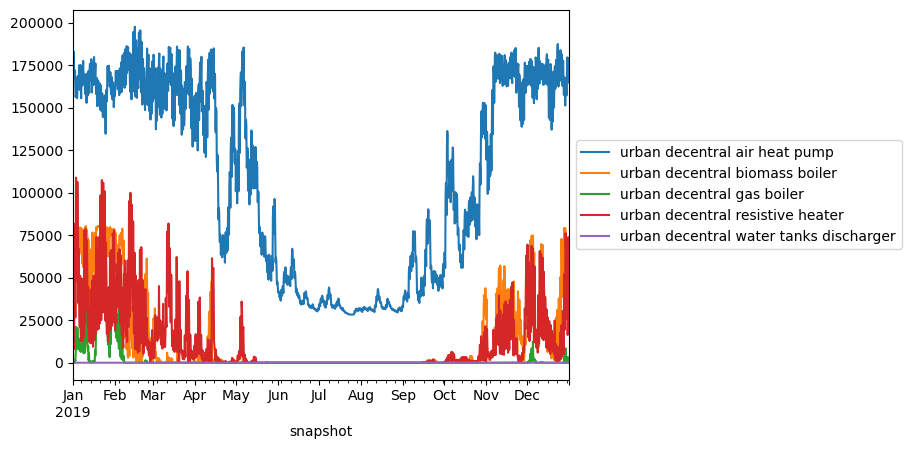

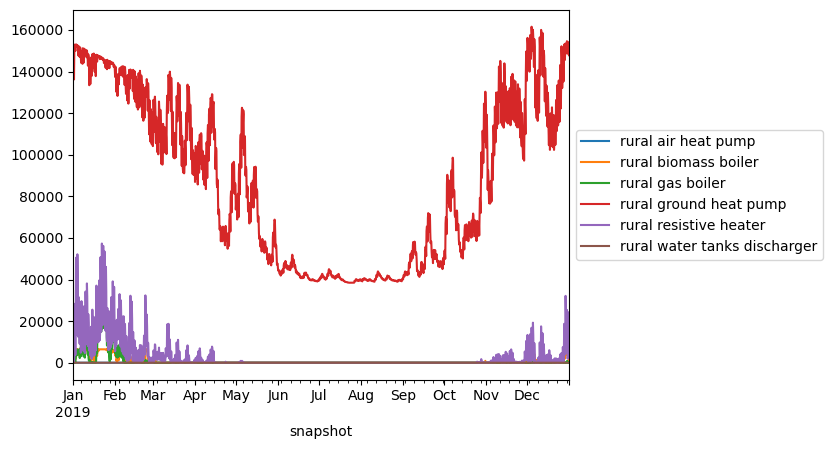

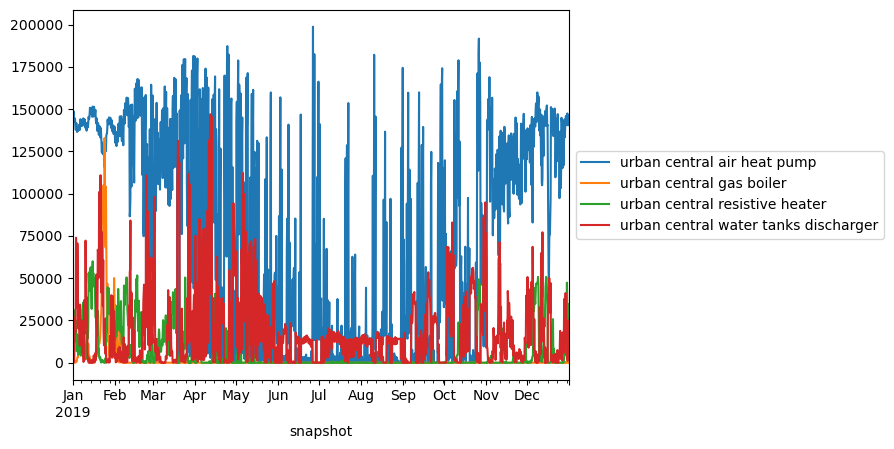

In [365]:
network = no_dac_no_heat_flex_2040
relevant_buses = ['urban decentral heat']
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
(relevant_links.T.groupby(network.links.carrier).sum().T * -1).plot()
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


network = no_dac_no_heat_flex_2040
relevant_buses = [ 'rural heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
(relevant_links.T.groupby(network.links.carrier).sum().T * -1).plot()
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

network = no_dac_no_heat_flex_2040
relevant_buses = ['urban central heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
(relevant_links.T.groupby(network.links.carrier).sum().T * -1).plot()
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))



Text(0.5, 1.0, 'Water tank discharge over the course of the year, no DAC and no additional heat storage sceanrio')

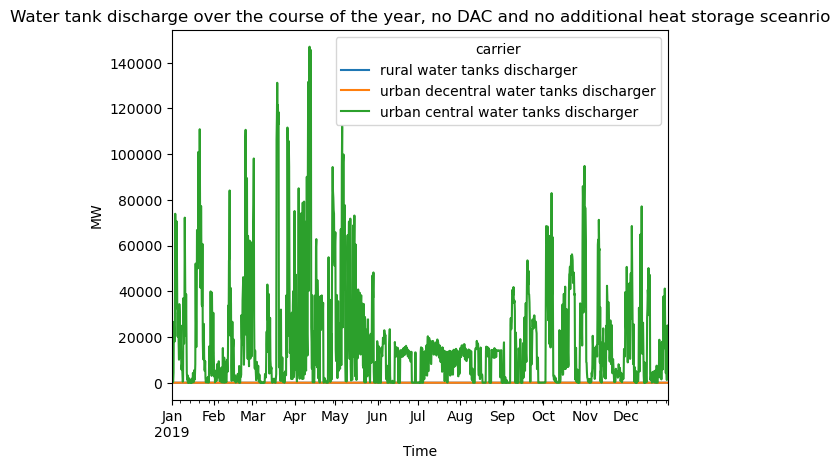

In [379]:
network = no_dac_no_heat_flex_2040
relevant_buses = ['urban decentral heat', 'rural heat', 'urban central heat']
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]
relevant_links = relevant_links.T
relevant_links = relevant_links.groupby(network.links.carrier).sum()
(relevant_links.loc[['rural water tanks discharger', 'urban decentral water tanks discharger' , 'urban central water tanks discharger']]*-1).T.plot()
plt.ylabel('MW')
plt.xlabel('Time')
plt.title('Water tank discharge over the course of the year, no DAC and no additional heat storage sceanrio')

Text(0.5, 1.0, 'Water tank discharge over the course of the year, no DAC and additional heat storage sceanrio')

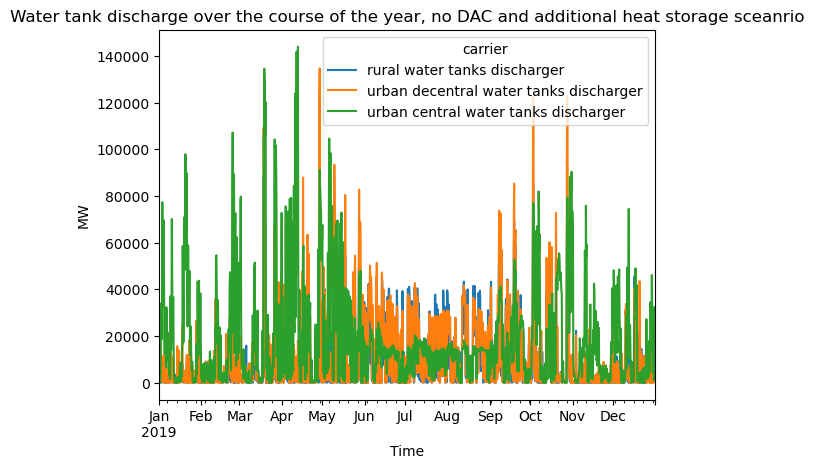

In [381]:
network = no_dac_heat_flex_2040
relevant_buses = ['urban decentral heat', 'rural heat', 'urban central heat']
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]
relevant_links = relevant_links.T
relevant_links = relevant_links.groupby(network.links.carrier).sum()
(relevant_links.loc[['rural water tanks discharger', 'urban decentral water tanks discharger' , 'urban central water tanks discharger']]*-1).T.plot()
plt.ylabel('MW')
plt.xlabel('Time')
plt.title('Water tank discharge over the course of the year, no DAC and additional heat storage sceanrio')

Text(0.5, 1.0, 'Urban Central Heat Relevant Heating Components Dispatch, no dac system')

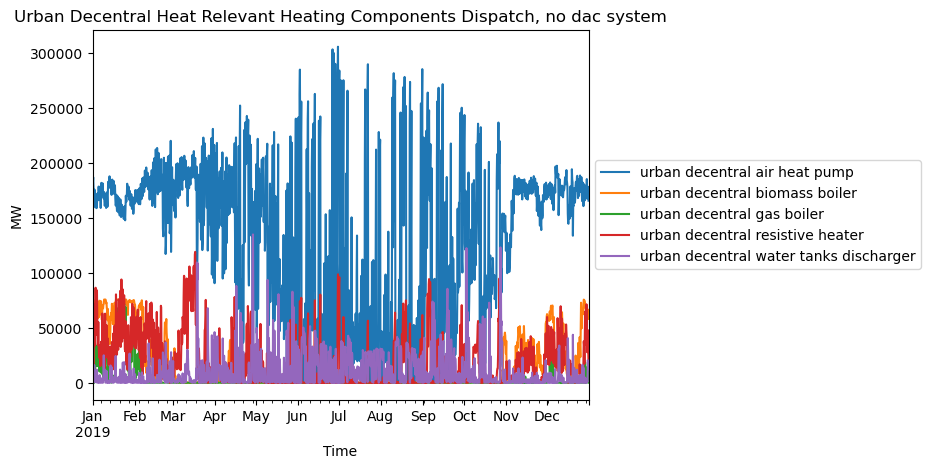

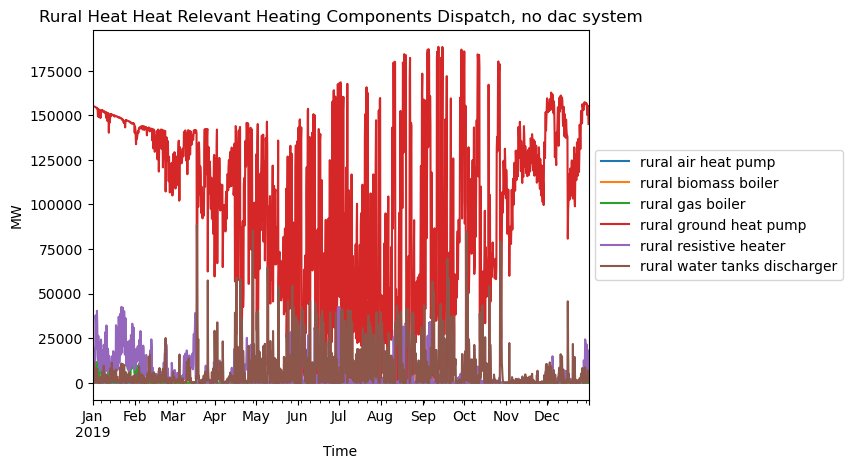

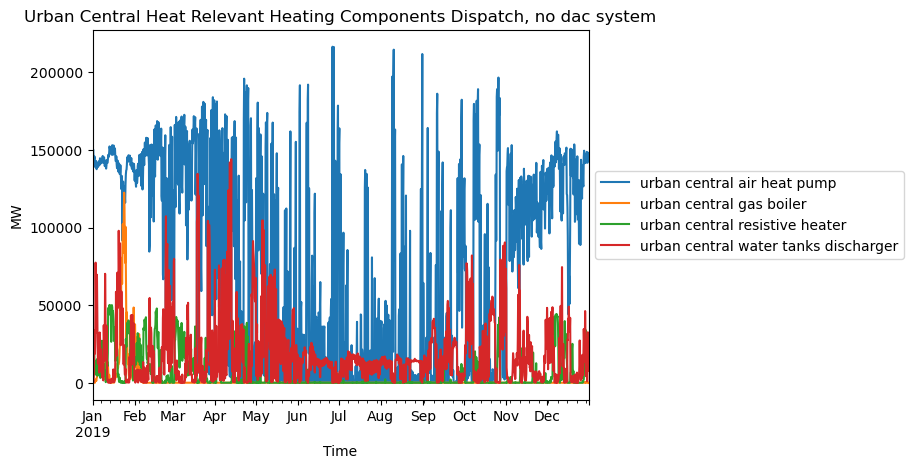

In [476]:
network = no_dac_heat_flex_2040
relevant_buses = ['urban decentral heat']
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
(relevant_links.T.groupby(network.links.carrier).sum().T * -1).plot()
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('MW')
plt.xlabel('Time')
plt.title('Urban Decentral Heat Relevant Heating Components Dispatch, no dac system')


network = no_dac_heat_flex_2040
relevant_buses = [ 'rural heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
(relevant_links.T.groupby(network.links.carrier).sum().T * -1).plot()
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('MW')
plt.xlabel('Time')
plt.title('Rural Heat Heat Relevant Heating Components Dispatch, no dac system')



network = no_dac_heat_flex_2040
relevant_buses = ['urban central heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
(relevant_links.T.groupby(network.links.carrier).sum().T * -1).plot()
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('MW')
plt.xlabel('Time')
plt.title('Urban Central Heat Relevant Heating Components Dispatch, no dac system')



Text(0.5, 1.0, 'Urban Decentral Air Source Heat Pump Dispatch')

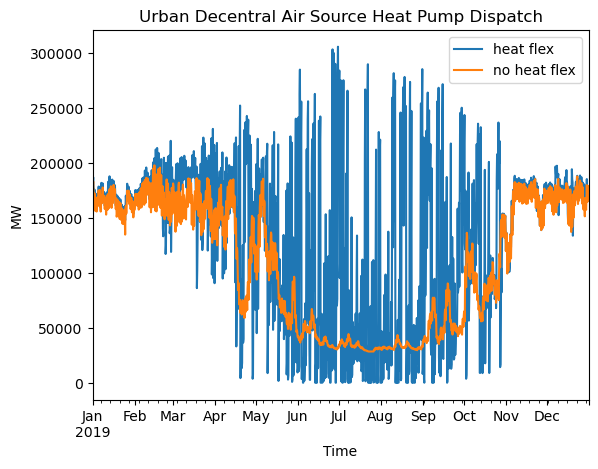

In [402]:
#how does a urban decentral heat pump behave between the no heat flex and heat flex scenarios? does the rolling mean maybe indicate that it is less used? 
network = no_dac_no_heat_flex_2040
relevant_buses = ['urban decentral heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
relevant_links = (relevant_links.T.groupby(network.links.carrier).sum().T * -1)
relevant_links = relevant_links['urban decentral air heat pump'].copy()

network = no_dac_heat_flex_2040
relevant_buses = ['urban decentral heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links1 = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links1 = network.links_t.p1[relevant_links1]  #power delivered to the heat buses in the links
relevant_links1 = (relevant_links1.T.groupby(network.links.carrier).sum().T * -1)
relevant_links1 = relevant_links1['urban decentral air heat pump'].copy()

comparison_dataframe = pd.DataFrame()
comparison_dataframe['heat flex'] = relevant_links1
comparison_dataframe['no heat flex'] = relevant_links
comparison_dataframe.plot()
plt.ylabel('MW')
plt.xlabel('Time')
plt.title('Urban Decentral Air Source Heat Pump Dispatch')


In [486]:
#for the year 2040
no_heat_flex_system = [no_dac_no_heat_flex_2040.objective, dac_no_heat_flex_2040.objective]
heat_flex_systems = [no_dac_heat_flex_2040.objective, dac_heat_flex_2040.objective]
comparison_dataframe = pd.DataFrame()
comparison_dataframe[0] = np.zeros(2)
comparison_dataframe[1] = np.zeros(2)
comparison_dataframe.columns = ['no dac [EUR]', 'dac [EUR]']
comparison_dataframe.loc['no heat flex'] = no_heat_flex_system
comparison_dataframe.loc['heat flex'] = heat_flex_systems
comparison_dataframe = comparison_dataframe.drop(0)
comparison_dataframe = comparison_dataframe.drop(1)
comparison_dataframe

#The system with heating flexibility is marginally less expensive 

no dac [EUR]     dac [EUR]
no heat flex  6.020454e+11  5.988852e+11
heat flex     5.996341e+11  5.967504e+11

Text(0.5, 1.0, 'Urban Central Heat Relevant Heating Components Dispatch, dac system')

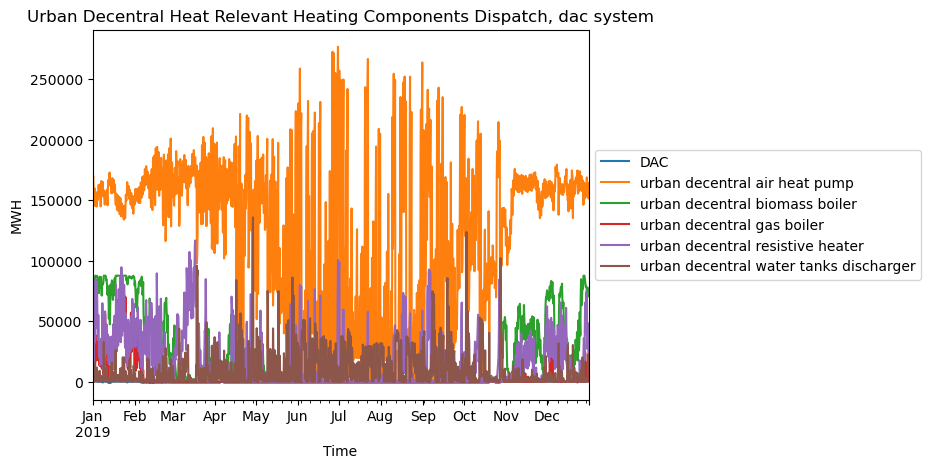

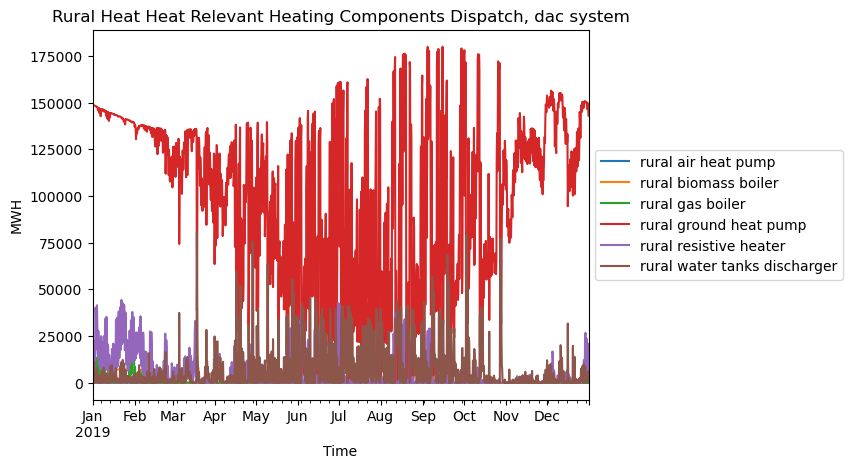

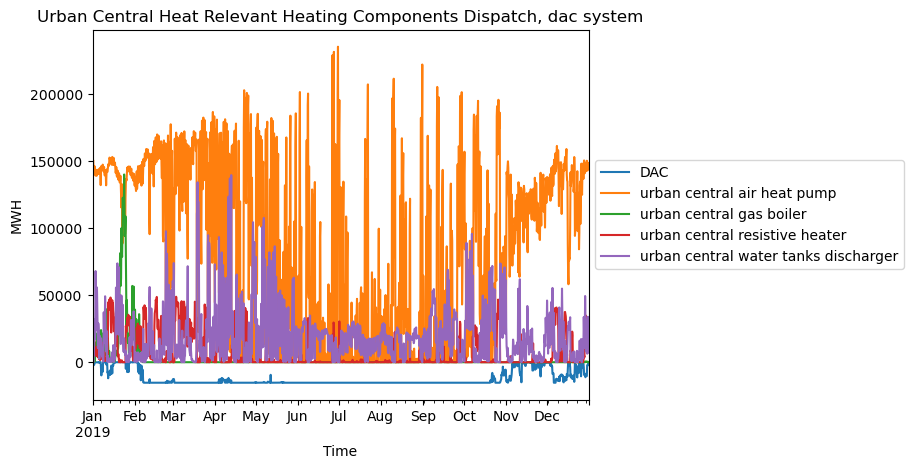

In [416]:
network = dac_heat_flex_2040
relevant_buses = ['urban decentral heat']
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
(relevant_links.T.groupby(network.links.carrier).sum().T * -1).plot()
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('MWH')
plt.xlabel('Time')
plt.title('Urban Decentral Heat Relevant Heating Components Dispatch, dac system')


network = dac_heat_flex_2040
relevant_buses = [ 'rural heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
(relevant_links.T.groupby(network.links.carrier).sum().T * -1).plot()
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('MWH')
plt.xlabel('Time')
plt.title('Rural Heat Heat Relevant Heating Components Dispatch, dac system')



network = dac_heat_flex_2040
relevant_buses = ['urban central heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
(relevant_links.T.groupby(network.links.carrier).sum().T * -1).plot()
# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('MWH')
plt.xlabel('Time')
plt.title('Urban Central Heat Relevant Heating Components Dispatch, dac system')



Text(0.5, 1.0, 'Urban Central Water Tanks Discharger')

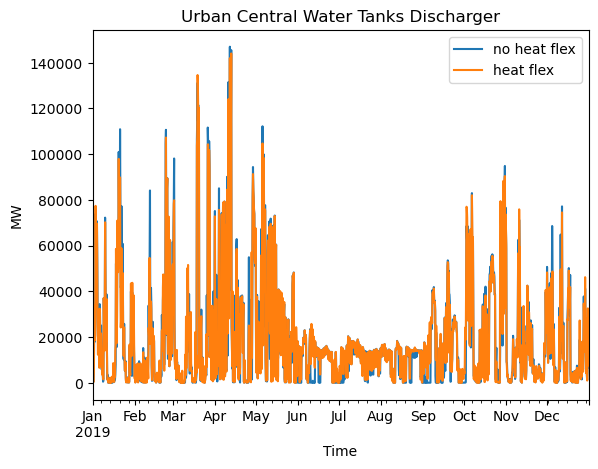

In [439]:
network = no_dac_no_heat_flex_2040
relevant_buses = ['urban central heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links = network.links_t.p1[relevant_links]  #power delivered to the heat buses in the links
relevant_links = (relevant_links.T.groupby(network.links.carrier).sum().T * -1)
relevant_links = relevant_links['urban central water tanks discharger'].copy()

network = no_dac_heat_flex_2040
relevant_buses = ['urban central heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links1 = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
relevant_links1 = network.links_t.p1[relevant_links1]  #power delivered to the heat buses in the links
relevant_links1 = (relevant_links1.T.groupby(network.links.carrier).sum().T * -1)
relevant_links1 = relevant_links1['urban central water tanks discharger'].copy()

comparison_dataframe = pd.DataFrame()
comparison_dataframe['no heat flex'] = relevant_links
comparison_dataframe['heat flex'] = relevant_links1
comparison_dataframe.plot()
plt.ylabel('MW')
plt.xlabel('Time')
plt.title('Urban Central Water Tanks Discharger')
#pretty simillar amount of use 


In [ ]:
#and they are the same size? or has more been added to urban central? 
network = no_dac_no_heat_flex_2040
relevant_buses = ['urban central heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
print(network.links.loc[relevant_links].p_nom_opt.sum())

network = no_dac_heat_flex_2040
relevant_buses = ['urban central heat'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index #all the links that are delivering to the heat buses
network.links.loc[relevant_links].p_nom.sum()
print(network.links.loc[relevant_links].p_nom_opt.sum()) 


#less nominal power in heat flex model? 

network = no_dac_no_heat_flex_2040
relevant_buses = ['urban central water tanks'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_stores = network.stores[network.stores.bus.isin(relevant_buses)].index #all the links that are delivering to the heat buses
print(network.stores.loc[relevant_stores].e_nom_opt.sum())

network = no_dac_heat_flex_2040
relevant_buses = ['urban central water tanks'] 
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_stores = network.stores[network.stores.bus.isin(relevant_buses)].index #all the links that are delivering to the heat buses
print(network.stores.loc[relevant_stores].e_nom_opt.sum())

#YES Urban central also has more capcity in it's stores during the time when additional water tanks are instutited, 
# buuut it doesn't really use them all that much more according to the graph above. 


521997.5930577746
508886.7874667742
9598003.821670068
73795454.86130795


In [470]:
#is there less buildout of the heating technologies? Is a smaller fleet utilized more? Nope, the fleet is larger
network = dac_no_heat_flex_2040
relevant_buses = ['urban decentral heat']
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index
relevant_links = network.links.loc[relevant_links]
print(relevant_links.p_nom_opt.sum())
#total p_nom_opt, conventional_ones, renewables ones 
conventional_p_nom_opt = relevant_links.loc[(relevant_links.carrier.isin(['urban decentral biomass boiler', 'urban decentral gas boiler']))].index
conventional_p_nom_opt = relevant_links.loc[conventional_p_nom_opt]

renewable_p_nom_opt = relevant_links.loc[(relevant_links.carrier.isin([ 'urban decentral air heat pump', 'urban decentral resistive heater','urban decentral water tanks discharger']))].index
renewable_p_nom_opt = relevant_links.loc[renewable_p_nom_opt]

no_heat_flex_info = [relevant_links.p_nom_opt.sum(), conventional_p_nom_opt.p_nom_opt.sum(), renewable_p_nom_opt.p_nom_opt.sum()]

network = dac_heat_flex_2040
relevant_buses = ['urban decentral heat']
relevant_buses = network.buses[network.buses.carrier.isin(relevant_buses)].index
relevant_links = network.links[network.links.bus1.isin(relevant_buses)].index
relevant_links = network.links.loc[relevant_links]
#total p_nom_opt 
print(relevant_links.p_nom_opt.sum())
conventional_p_nom_opt = relevant_links.loc[(relevant_links.carrier.isin(['urban decentral biomass boiler', 'urban decentral gas boiler']))].index
conventional_p_nom_opt = relevant_links.loc[conventional_p_nom_opt]
renewable_p_nom_opt = relevant_links.loc[(relevant_links.carrier.isin([ 'urban decentral air heat pump', 'urban decentral resistive heater','urban decentral water tanks discharger']))].index
renewable_p_nom_opt = relevant_links.loc[renewable_p_nom_opt]

heat_flex_info = [relevant_links.p_nom_opt.sum(), conventional_p_nom_opt.p_nom_opt.sum(), renewable_p_nom_opt.p_nom_opt.sum()]


#is is that there is a different 
no_heat_flex_info

429855.2440320411
577386.6138660305


[429855.2440320411, 177873.58437868886, 251959.48930269122]

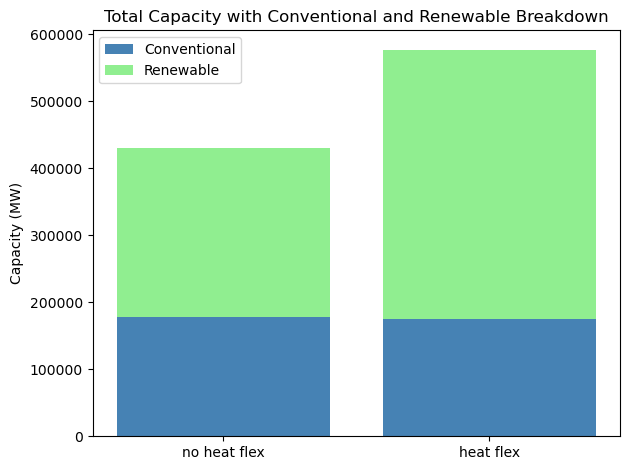

In [487]:
import matplotlib.pyplot as plt
import numpy as np

# Input: each bar is [total, conventional, renewable]
bar1 = no_heat_flex_info #no heat flex bar 
bar2 = heat_flex_info #heat flex bar

# Combine into one list
bars = [bar1, bar2]

# Extract components
conventionals = [bar[1] for bar in bars]
renewables = [bar[2] for bar in bars]

# Bar positions
x = np.arange(len(bars))

# Plotting
fig, ax = plt.subplots()
ax.bar(x, conventionals, label='Conventional', color='steelblue')
ax.bar(x, renewables, bottom=conventionals, label='Renewable', color='lightgreen')

# Labels and styling
ax.set_ylabel('Capacity (MW)')
ax.set_title('Total Capacity with Conventional and Renewable Breakdown')
ax.set_xticks(x)
ax.set_xticklabels(['no heat flex', 'heat flex'])
ax.legend()

plt.tight_layout()
plt.show()


## Should the additional stores only be added to heating buses that have more residential makeups (which I assume are urban decentral and rural, but will check below?):


Otherwise I'm added additional storage capacity base on (store size * .5 * Eurostat households), but they may not be applied to regions witho the most households. Should I distribute them according to population, or is there a housing density section?

In [498]:
network.loads

bus               carrier  \
Load                                                                           
AL0 0                                AL0 0 low voltage           electricity   
AT0 0                                AT0 0 low voltage           electricity   
BA0 0                                BA0 0 low voltage           electricity   
BE0 0                                BE0 0 low voltage           electricity   
BG0 0                                BG0 0 low voltage           electricity   
...                                                ...                   ...   
SI0 0 urban decentral heat  SI0 0 urban decentral heat  urban decentral heat   
SK0 0 rural heat                      SK0 0 rural heat            rural heat   
SK0 0 urban decentral heat  SK0 0 urban decentral heat  urban decentral heat   
XK0 0 rural heat                      XK0 0 rural heat            rural heat   
XK0 0 urban decentral heat  XK0 0 urban decentral heat  urban decentral heat   

                           type  p_set  q_set  sign  active  
Load                                                         
AL0 0                              0.0    0.0  -1.0    True  
AT0 0                              0.0    0.0  -1.0    True  
BA0 0                              0.0    0.0  -1.0    True  
BE0 0                              0.0    0.0  -1.0    True  
BG0 0                              0.0    0.0  -1.0    True  
...                         ...    ...    ...   ...     ...  
SI0 0 urban decentral heat         0.0    0.0  -1.0    True  
SK0 0 rural heat                   0.0    0.0  -1.0    True  
SK0 0 urban decentral heat         0.0    0.0  -1.0    True  
XK0 0 rural heat                   0.0    0.0  -1.0    True  
XK0 0 urban decentral heat         0.0    0.0  -1.0    True  

[666 rows x 7 columns]

## Does it change the renewable makeup? 

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/3560069763.py:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/3560069763.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/3560069763.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/

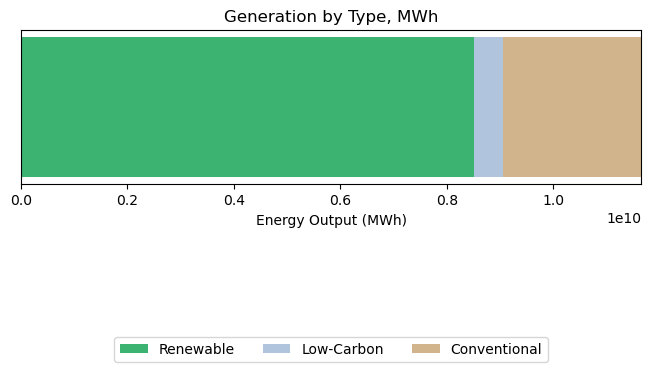

In [178]:
#This is purely a question of generation 
#I want those bars horizontally where they are broken up by type 


#does solar rooftop go towards heating exclusively or also to the low level electricity bus?
# It goes to the low voltage bus == renewable electricity 

network = no_dac_no_heat_flex_2040
network.statistics().Supply.loc['Generator'] #supply is what is actually given 
renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'rural solar thermal', 'urban decentral solar thermal', 'urban central solar thermal', 'ror']
renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)].index 
low_carbon_carriers = ['nuclear', 'geothermal']
traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass', ]

renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
low_carbon_production = (network.generators_t.p[(network.generators[network.generators.carrier.isin(low_carbon_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
conventional_production =  (network.generators_t.p[(network.generators[network.generators.carrier.isin(traditional_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 

def stacked_side_bar():
    # Sample data: each value is a segment of the stacked bar
    categories = ['Renewable', 'Low-Carbon', 'Conventional']
    values = [renewable_production.sum(), low_carbon_production.sum(), conventional_production.sum()]
    colors = ['mediumseagreen', 'lightsteelblue', 'tan']

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 2))

    # Plot horizontal stacked bar
    left = 0
    for val, color, label in zip(values, colors, categories):
        ax.barh(y=0, width=val, left=left, color=color, label=label)
        left += val

    # Formatting
    ax.set_yticks([])  # Hide y-axis tick
    ax.set_xlim(0, sum(values))
    ax.set_xlabel("Energy Output (MWh)")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -1.2), ncol=len(categories))
    ax.set_title("Generation by Type, MWh")

    plt.tight_layout()
    plt.show()

stacked_side_bar()

In [490]:
network.generators.carrier.unique()

array(['nuclear', 'geothermal', 'offwind-float', 'offwind-dc', 'onwind',
       'solar-hsat', 'solar', 'offwind-ac', 'ror', 'lignite', 'coal',
       'oil primary', 'gas', 'urban central heat vent',
       'urban central solar thermal', 'biogas', 'solid biomass',
       'solar rooftop', 'rural solar thermal',
       'urban decentral solar thermal'], dtype=object)

In [ ]:
import matplotlib.pyplot as plt


def stacked_side_bar(network_choice):
    #to get rid of the depreciation warnings
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    network = network_choice
    #data from network
    renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'rural solar thermal', 'urban decentral solar thermal', 'urban central solar thermal', 'ror']
    renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)].index 
    low_carbon_carriers = ['nuclear', 'geothermal']
    traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass']

    renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    low_carbon_production = (network.generators_t.p[(network.generators[network.generators.carrier.isin(low_carbon_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    conventional_production =  (network.generators_t.p[(network.generators[network.generators.carrier.isin(traditional_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
 

    # Your actual categories and summed values (replace these with your actual data if running)
    categories = ['Renewable', 'Low-Carbon', 'Conventional']
    values = [renewable_production.sum(), low_carbon_production.sum(), conventional_production.sum()]
    colors = ["#3B9357", "#799CAD", "#645744"]  # green, blue-gray, brown

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 2.5))

    # Plot stacked horizontal bar
    left = 0
    bar_height = 0.6
    for val, color in zip(values, colors):
        ax.barh(y=0, width=val, left=left, height=bar_height,
                color=color, edgecolor='black', linewidth=1.5)
        left += val

    # Add labels with lines pointing to right-side annotations
    left = 0
    total = sum(values)
    for label, val in zip(categories, values):
        bar_center_x = left + val / 2
        segment_center_x = left + val / 2
        segment_centre_y = 0.10
        label_x = right_edge_x + 0.02 * total  # offset to the right
        label_y = 0.55  # vertical position of the label

        # Draw the connecting line
        ax.plot([bar_center_x,segment_center_x], [segment_centre_y, label_y - 0.15],
                color='black', linewidth=1.0)

        # Format value in scientific notation (rounded to 2 decimal places)
        sci_val = "{:.2e}".format(val)
        pct_val = str(((val/total) * 100).round(2))

        # Draw label and value
        ax.text(segment_center_x, label_y, label, ha='center', va='bottom', fontsize=10)
        ax.text(segment_center_x, label_y - 0.05, sci_val, ha='center', va='top', fontsize=9, color='gray')
        ax.text(segment_center_x, segment_centre_y - .2, pct_val + '%', ha = 'center', va = 'bottom', fontsize = 9, color = 'k')


        left += val

    # Final plot adjustments
    ax.set_xlim(0, total * 1.15)
    ax.set_ylim(-0.5, 0.7)
    ax.set_yticks([])
    ax.set_xlabel("Generation [MWh]", fontsize=12)
    ax.set_title("Power Contribution by Technology Group", fontsize=14, pad=15)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    #ax.grid(axis='x', linestyle='--', alpha=0.1)

    plt.tight_layout()
    plt.show()
    plt.close()
    return fig


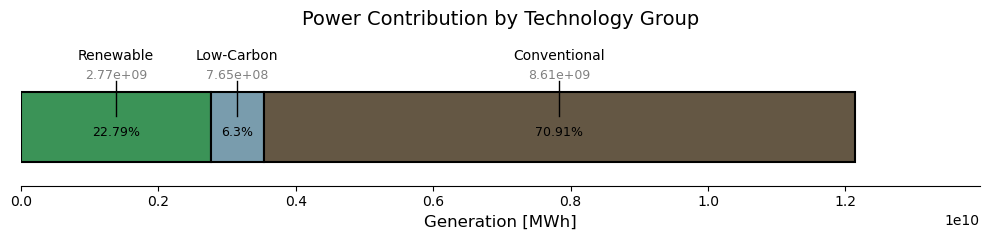

In [235]:
stacked_side_bar(no_dac_no_heat_flex_2030)

In [ ]:
#Ok first problem, we're underestimating renewables -- or not because this is the entire system including other sectors?

no dac


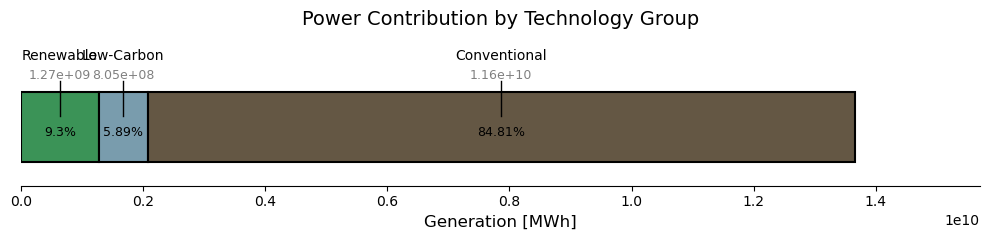

dac


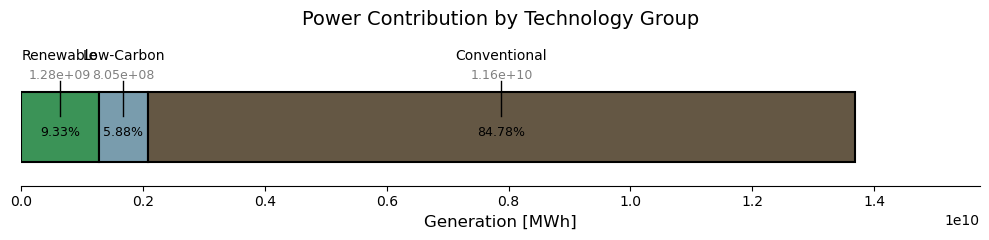

In [241]:
#and does dac change the renewable mix? 
print('no dac')
figure1 = stacked_side_bar(no_dac_no_heat_flex_2020)
figure1
print('dac')
figure2 = stacked_side_bar(dac_heat_flex_2020)
plt.show(figure2)

no dac


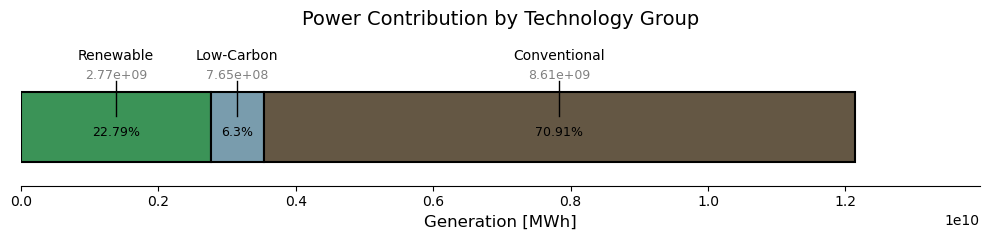

dac


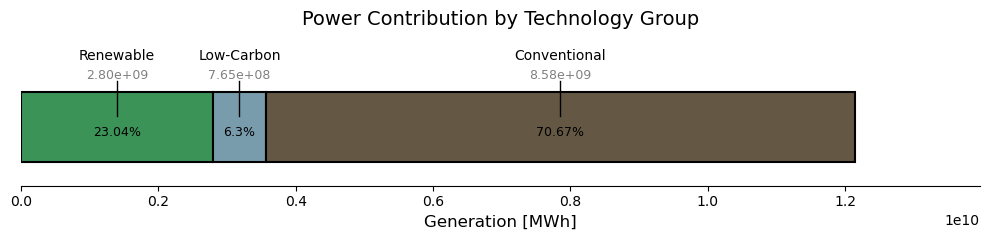

In [243]:
#and does dac change the renewable mix? 
print('no dac')
figure1 = stacked_side_bar(no_dac_no_heat_flex_2030)
figure1
print('dac')
figure2 = stacked_side_bar(dac_heat_flex_2030)
plt.show(figure2)

no dac


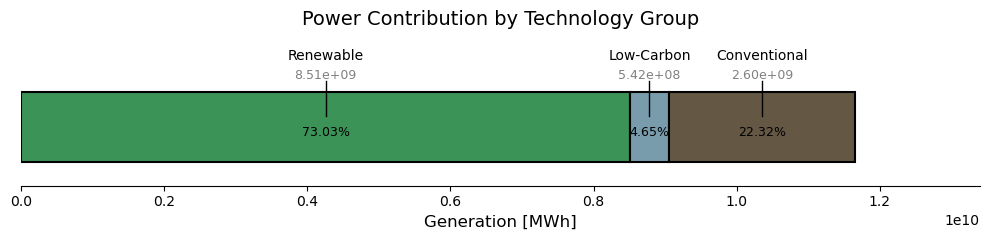

dac


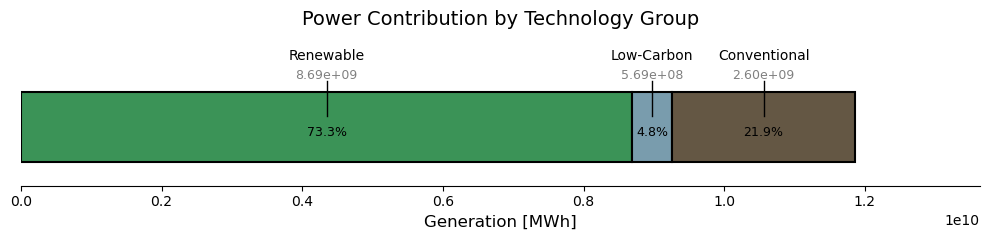

In [244]:
#and does dac change the renewable mix? 
print('no dac')
figure1 = stacked_side_bar(no_dac_no_heat_flex_2040)
figure1
print('dac')
figure2 = stacked_side_bar(dac_heat_flex_2040)
plt.show(figure2)

no dac


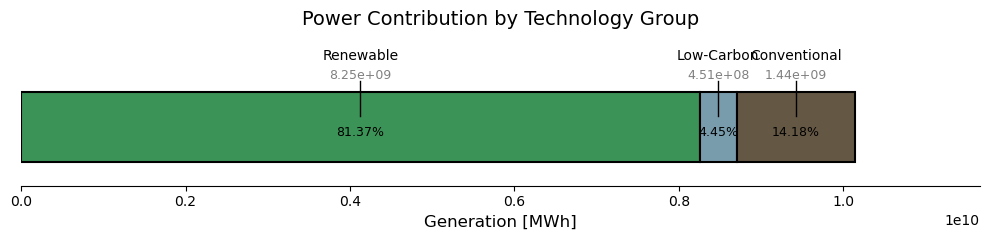

dac


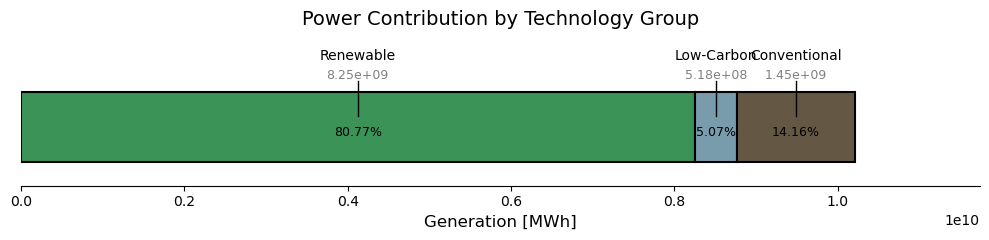

In [245]:
#and does dac change the renewable mix? 
print('no dac')
figure1 = stacked_side_bar(no_dac_no_heat_flex_2050)
figure1
print('dac')
figure2 = stacked_side_bar(dac_heat_flex_2050)
plt.show(figure2)

In [ ]:
#one percent difference in supply
#what is considered a meaningful change in generation? 

In [ ]:
#is there not enough renewables in the early years, as in [not nearly enough compared to what there hould be], because non-electricity sectors are included? 
#what if I just include the electricty sector? 

/Users/katherine.shaw/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x464357dd0>,
 <matplotlib.collections.LineCollection at 0x46478bbc0>)

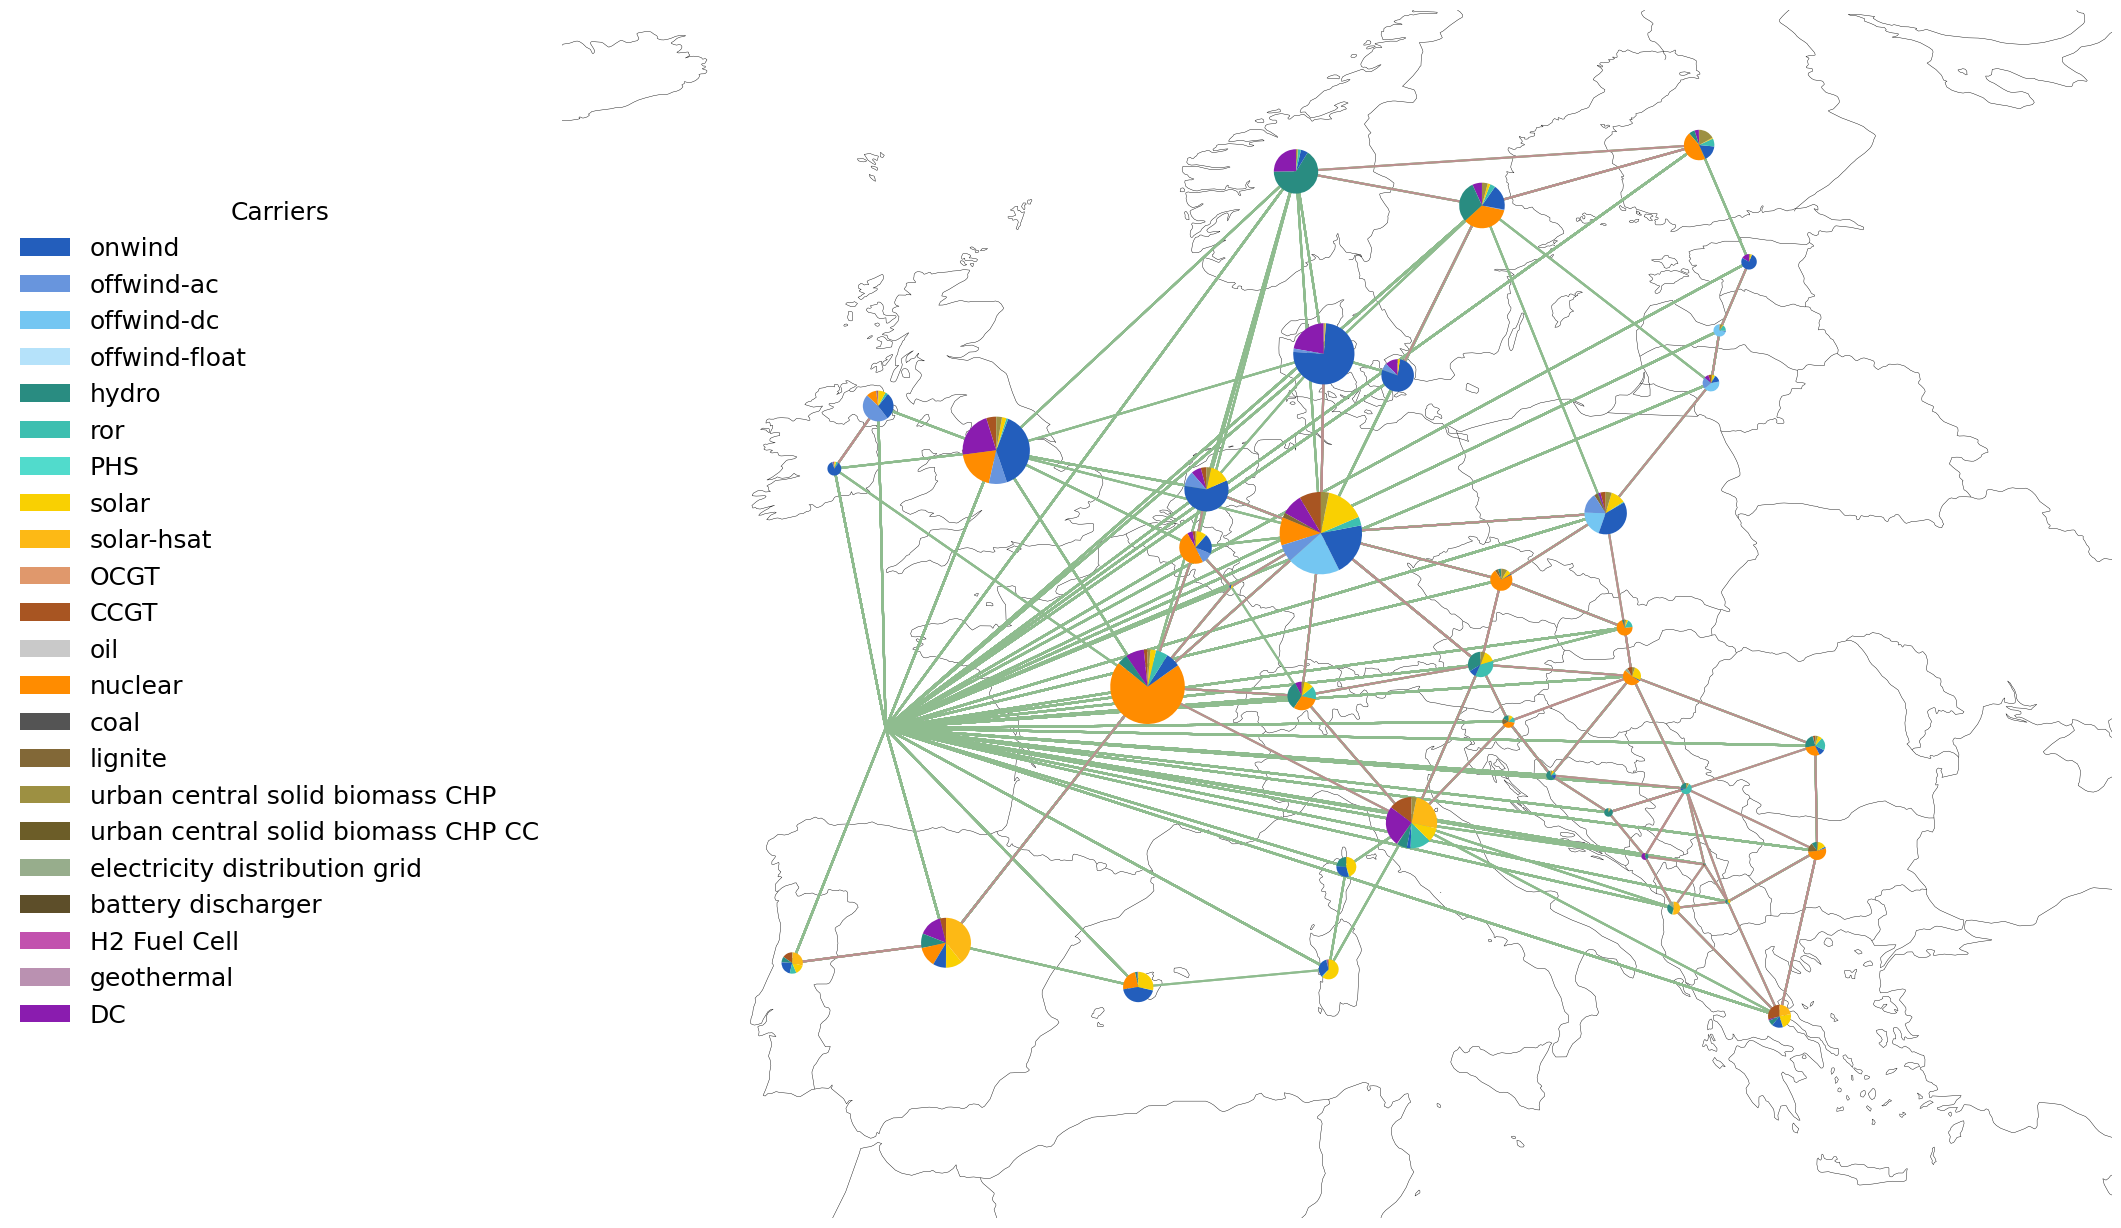

In [249]:
af.plot_network_test(no_dac_no_heat_flex_2030, 'electric')

In [ ]:
#if I'm rewriting the bar chart above to be just the electricity sector... 
import matplotlib.pyplot as plt


def stacked_side_bar(network_choice):
    #to get rid of the depreciation warnings
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    network = network_choice
    #data from network
    renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'rural solar thermal', 'urban decentral solar thermal', 'urban central solar thermal', 'ror']
    renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)].index 
    low_carbon_carriers = ['nuclear', 'geothermal']
    traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass']

    renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    low_carbon_production = (network.generators_t.p[(network.generators[network.generators.carrier.isin(low_carbon_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    conventional_production =  (network.generators_t.p[(network.generators[network.generators.carrier.isin(traditional_carriers)].index)] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
 

    # Your actual categories and summed values (replace these with your actual data if running)
    categories = ['Renewable', 'Low-Carbon', 'Conventional']
    values = [renewable_production.sum(), low_carbon_production.sum(), conventional_production.sum()]
    colors = ["#3B9357", "#799CAD", "#645744"]  # green, blue-gray, brown

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 2.5))

    # Plot stacked horizontal bar
    left = 0
    bar_height = 0.6
    for val, color in zip(values, colors):
        ax.barh(y=0, width=val, left=left, height=bar_height,
                color=color, edgecolor='black', linewidth=1.5)
        left += val

    # Add labels with lines pointing to right-side annotations
    left = 0
    total = sum(values)
    for label, val in zip(categories, values):
        bar_center_x = left + val / 2
        segment_center_x = left + val / 2
        segment_centre_y = 0.10
        label_x = right_edge_x + 0.02 * total  # offset to the right
        label_y = 0.55  # vertical position of the label

        # Draw the connecting line
        ax.plot([bar_center_x,segment_center_x], [segment_centre_y, label_y - 0.15],
                color='black', linewidth=1.0)

        # Format value in scientific notation (rounded to 2 decimal places)
        sci_val = "{:.2e}".format(val)
        pct_val = str(((val/total) * 100).round(2))

        # Draw label and value
        ax.text(segment_center_x, label_y, label, ha='center', va='bottom', fontsize=10)
        ax.text(segment_center_x, label_y - 0.05, sci_val, ha='center', va='top', fontsize=9, color='gray')
        ax.text(segment_center_x, segment_centre_y - .2, pct_val + '%', ha = 'center', va = 'bottom', fontsize = 9, color = 'k')


        left += val

    # Final plot adjustments
    ax.set_xlim(0, total * 1.15)
    ax.set_ylim(-0.5, 0.7)
    ax.set_yticks([])
    ax.set_xlabel("Generation [MWh]", fontsize=12)
    ax.set_title("Power Contribution by Technology Group", fontsize=14, pad=15)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    #ax.grid(axis='x', linestyle='--', alpha=0.1)

    plt.tight_layout()
    plt.show()
    plt.close()
    return fig


In [287]:
#data from network
renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'rural solar thermal', 'urban decentral solar thermal', 'urban central solar thermal', 'ror']
low_carbon_carriers = ['nuclear', 'geothermal']
traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass', ]

#all buses that are acceptable 
electric_buses = network.buses[network.buses.unit == 'MWh_el'].index #AC, battery, EV battery, low voltage, home battery 
renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)]
renewable_generators = renewable_generators[renewable_generators.bus.isin(electric_buses)]
renewable_generators = renewable_generators.index

low_carbon_generators = network.generators[network.generators.carrier.isin(low_carbon_carriers)]
low_carbon_generators = low_carbon_generators[low_carbon_generators.bus.isin(electric_buses)]
low_carbon_generators = low_carbon_generators.index

#conventional generators harder to nab, if I want to get to what was contributed to the power sector, have to take a different approach 
conventional_generators = network.generators[network.generators.carrier.isin(traditional_carriers)]
#conventional_generators = conventional_generators[conventional_generators.bus.isin(electric_buses)]
#conventional_generators = conventional_generators.index 
conventional_generators

network.links.carrier.unique()
#need all the links that come from a conventional bus and go into a electric bus
thermal_to_power = network.links[network.links.bus1.isin(electric_buses)][~network.links.bus0.isin(electric_buses)]
thermal_to_power = thermal_to_power[~(thermal_to_power.carrier == 'nuclear')]#get rid of all nuclear, because that is one I already have in low carbon power
thermal_to_power = thermal_to_power.index 



/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/231446312.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
low_carbon_production = (network.generators_t.p[low_carbon_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
conventional_production =  (network.links_t.p1[thermal_to_power] * network.snapshot_weightings.objective[0]).T.groupby(network.links.carrier).sum().T.sum() #MWh
conventional_production = conventional_production * -1 #because it's power delivered to the electric bus 
conventional_production

carrier
CCGT                                  2.338776e+06
H2 Fuel Cell                          9.455864e+00
OCGT                                  7.676756e+00
coal                                  4.319834e+00
lignite                               3.736017e+00
oil                                   1.871444e+00
urban central CHP                     1.035589e+01
urban central CHP CC                  1.024314e+01
urban central solid biomass CHP       1.911249e+07
urban central solid biomass CHP CC    2.394548e+07
dtype: float64

In [491]:
network.generators[network.generators.carrier == 'rural solar thermal']

bus control type  \
Generator                                                                 
AL0 0 rural solar thermal collector-2040  AL0 0 rural heat      PQ        
AT0 0 rural solar thermal collector-2040  AT0 0 rural heat      PQ        
BA0 0 rural solar thermal collector-2040  BA0 0 rural heat      PQ        
BE0 0 rural solar thermal collector-2040  BE0 0 rural heat      PQ        
BG0 0 rural solar thermal collector-2040  BG0 0 rural heat      PQ        
CH0 0 rural solar thermal collector-2040  CH0 0 rural heat      PQ        
CZ0 0 rural solar thermal collector-2040  CZ0 0 rural heat      PQ        
DE0 0 rural solar thermal collector-2040  DE0 0 rural heat      PQ        
DK0 0 rural solar thermal collector-2040  DK0 0 rural heat      PQ        
DK1 0 rural solar thermal collector-2040  DK1 0 rural heat      PQ        
EE0 0 rural solar thermal collector-2040  EE0 0 rural heat      PQ        
ES0 0 rural solar thermal collector-2040  ES0 0 rural heat      PQ        
ES6 0 rural solar thermal collector-2040  ES6 0 rural heat      PQ        
FI1 0 rural solar thermal collector-2040  FI1 0 rural heat      PQ        
FR0 0 rural solar thermal collector-2040  FR0 0 rural heat      PQ        
FR5 0 rural solar thermal collector-2040  FR5 0 rural heat      PQ        
GB2 0 rural solar thermal collector-2040  GB2 0 rural heat      PQ        
GB3 0 rural solar thermal collector-2040  GB3 0 rural heat      PQ        
GR0 0 rural solar thermal collector-2040  GR0 0 rural heat      PQ        
HR0 0 rural solar thermal collector-2040  HR0 0 rural heat      PQ        
HU0 0 rural solar thermal collector-2040  HU0 0 rural heat      PQ        
IE3 0 rural solar thermal collector-2040  IE3 0 rural heat      PQ        
IT0 0 rural solar thermal collector-2040  IT0 0 rural heat      PQ        
IT4 0 rural solar thermal collector-2040  IT4 0 rural heat      PQ        
LT0 0 rural solar thermal collector-2040  LT0 0 rural heat      PQ        
LU0 0 rural solar thermal collector-2040  LU0 0 rural heat      PQ        
LV0 0 rural solar thermal collector-2040  LV0 0 rural heat      PQ        
ME0 0 rural solar thermal collector-2040  ME0 0 rural heat      PQ        
MK0 0 rural solar thermal collector-2040  MK0 0 rural heat      PQ        
NL0 0 rural solar thermal collector-2040  NL0 0 rural heat      PQ        
NO1 0 rural solar thermal collector-2040  NO1 0 rural heat      PQ        
PL0 0 rural solar thermal collector-2040  PL0 0 rural heat      PQ        
PT0 0 rural solar thermal collector-2040  PT0 0 rural heat      PQ        
RO0 0 rural solar thermal collector-2040  RO0 0 rural heat      PQ        
RS0 0 rural solar thermal collector-2040  RS0 0 rural heat      PQ        
SE1 0 rural solar thermal collector-2040  SE1 0 rural heat      PQ        
SI0 0 rural solar thermal collector-2040  SI0 0 rural heat      PQ        
SK0 0 rural solar thermal collector-2040  SK0 0 rural heat      PQ        
XK0 0 rural solar thermal collector-2040  XK0 0 rural heat      PQ        

                                          p_nom  p_nom_mod  p_nom_extendable  \
Generator                                                                      
AL0 0 rural solar thermal collector-2040    0.0        0.0              True   
AT0 0 rural solar thermal collector-2040    0.0        0.0              True   
BA0 0 rural solar thermal collector-2040    0.0        0.0              True   
BE0 0 rural solar thermal collector-2040    0.0        0.0              True   
BG0 0 rural solar thermal collector-2040    0.0        0.0              True   
CH0 0 rural solar thermal collector-2040    0.0        0.0              True   
CZ0 0 rural solar thermal collector-2040    0.0        0.0              True   
DE0 0 rural solar thermal collector-2040    0.0        0.0              True   
DK0 0 rural solar thermal collector-2040    0.0        0.0              True   
DK1 0 rural solar thermal collector-2040    0.0        0.0              True   
EE0 0 rural solar t

In [492]:
#if I'm rewriting the bar chart above to be just the electricity sector... 
import matplotlib.pyplot as plt


def stacked_side_bar_electric(network_choice):
    #to get rid of the depreciation warnings
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    network = network_choice
    #data from network
   #data from network
    renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'ror'] #no solar thermal, though an argument could perhaps be made
    low_carbon_carriers = ['nuclear', 'geothermal']
    traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass', ]

    #all buses that are acceptable 
    electric_buses = network.buses[network.buses.unit == 'MWh_el'].index #AC, battery, EV battery, low voltage, home battery 
    renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)]
    renewable_generators = renewable_generators[renewable_generators.bus.isin(electric_buses)]
    renewable_generators = renewable_generators.index

    low_carbon_generators = network.generators[network.generators.carrier.isin(low_carbon_carriers)]
    low_carbon_generators = low_carbon_generators[low_carbon_generators.bus.isin(electric_buses)]
    low_carbon_generators = low_carbon_generators.index

    #conventional generators harder to nab, if I want to get to what was contributed to the power sector, have to take a different approach 
    conventional_generators = network.generators[network.generators.carrier.isin(traditional_carriers)]
    #conventional_generators = conventional_generators[conventional_generators.bus.isin(electric_buses)]
    #conventional_generators = conventional_generators.index 
    conventional_generators

    network.links.carrier.unique()
    #need all the links that come from a conventional bus and go into a electric bus
    thermal_to_power = network.links[network.links.bus1.isin(electric_buses)][~network.links.bus0.isin(electric_buses)]
    thermal_to_power = thermal_to_power[~(thermal_to_power.carrier == 'nuclear')]#get rid of all nuclear, because that is one I already have in low carbon power
    thermal_to_power = thermal_to_power.index 

    renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    low_carbon_production = (network.generators_t.p[low_carbon_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    conventional_production =  (network.links_t.p1[thermal_to_power] * network.snapshot_weightings.objective[0]).T.groupby(network.links.carrier).sum().T.sum() #MWh
    conventional_production = conventional_production * -1 #because it's power delivered to the electric bus 

    # Your actual categories and summed values (replace these with your actual data if running)
    categories = ['Renewable', 'Low-Carbon', 'Conventional']
    values = [renewable_production.sum(), low_carbon_production.sum(), conventional_production.sum()]
    colors = ["#3B9357", "#799CAD", "#645744"]  # green, blue-gray, brown

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 2.5))

    # Plot stacked horizontal bar
    left = 0
    bar_height = 0.6
    for val, color in zip(values, colors):
        ax.barh(y=0, width=val, left=left, height=bar_height,
                color=color, edgecolor='black', linewidth=1.5)
        left += val

    # Add labels with lines pointing to right-side annotations
    left = 0
    total = sum(values)
    for label, val in zip(categories, values):
        bar_center_x = left + val / 2
        segment_center_x = left + val / 2
        segment_centre_y = 0.10
        label_x = right_edge_x + 0.02 * total  # offset to the right
        label_y = 0.55  # vertical position of the label

        # Draw the connecting line
        ax.plot([bar_center_x,segment_center_x], [segment_centre_y, label_y - 0.15],
                color='black', linewidth=1.0)

        # Format value in scientific notation (rounded to 2 decimal places)
        sci_val = "{:.2e}".format(val)
        pct_val = str(((val/total) * 100).round(2))

        # Draw label and value
        ax.text(segment_center_x, label_y, label, ha='center', va='bottom', fontsize=10)
        ax.text(segment_center_x, label_y - 0.05, sci_val, ha='center', va='top', fontsize=9, color='gray')
        ax.text(segment_center_x, segment_centre_y - .2, pct_val + '%', ha = 'center', va = 'bottom', fontsize = 9, color = 'k')


        left += val

    # Final plot adjustments
    ax.set_xlim(0, total * 1.15)
    ax.set_ylim(-0.5, 0.7)
    ax.set_yticks([])
    ax.set_xlabel("Generation [MWh]", fontsize=12)
    ax.set_title("Power Contribution by Technology Group", fontsize=14, pad=15)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    #ax.grid(axis='x', linestyle='--', alpha=0.1)

    plt.tight_layout()
    plt.show()
    plt.close()
    #return fig


no dac, no heat flex


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1078376637.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



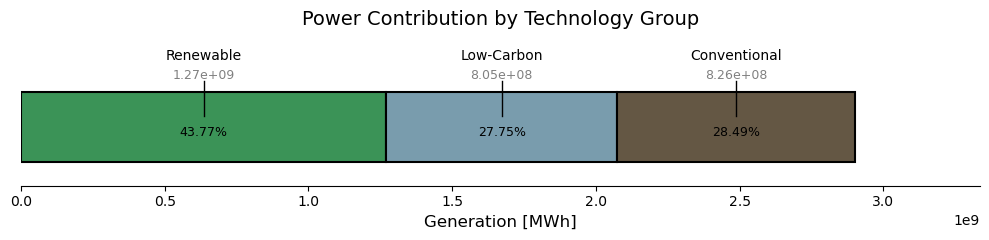

dac, no heat flex


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1078376637.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



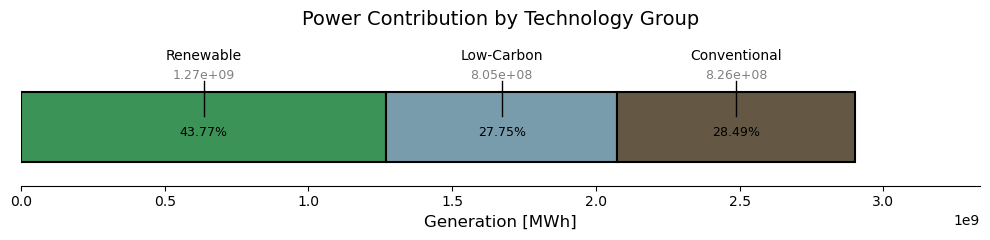

In [494]:
#2020 
print('no dac, no heat flex')
figure1 = stacked_side_bar_electric(no_dac_no_heat_flex_2020) #yeah ok it wasn't the case in the power sector, which is what we want to see
figure1
print('dac, no heat flex')
figure2 = stacked_side_bar_electric(dac_no_heat_flex_2020) #yeah ok it wasn't the case in the power sector, which is what we want to see
figure2

no dac, no heat flex


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1078376637.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



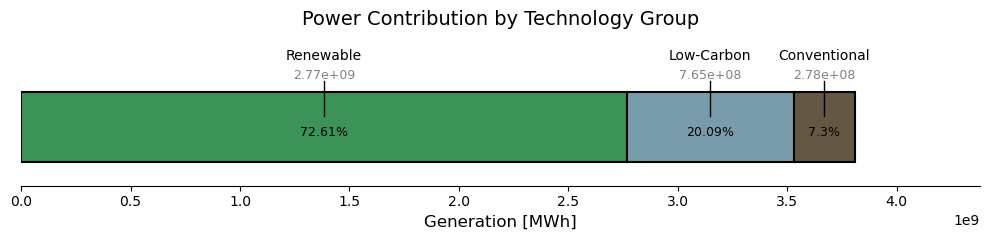

dac, no heat flex


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1078376637.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



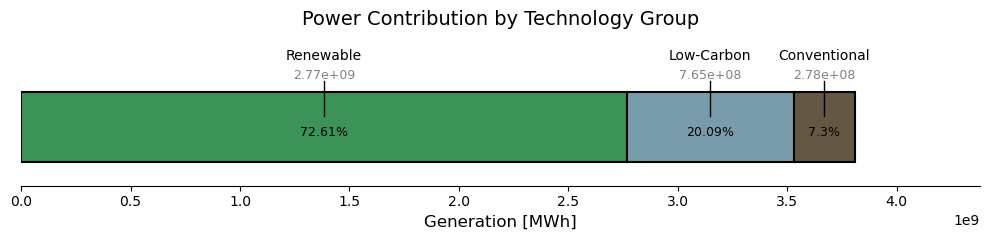

In [495]:
#2030 
print('no dac, no heat flex')
figure1 = stacked_side_bar_electric(no_dac_no_heat_flex_2030) #yeah ok it wasn't the case in the power sector, which is what we want to see
figure1
print('dac, no heat flex')
figure2 = stacked_side_bar_electric(dac_no_heat_flex_2030) #yeah ok it wasn't the case in the power sector, which is what we want to see
figure2 

no dac, no heat flex


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1078376637.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



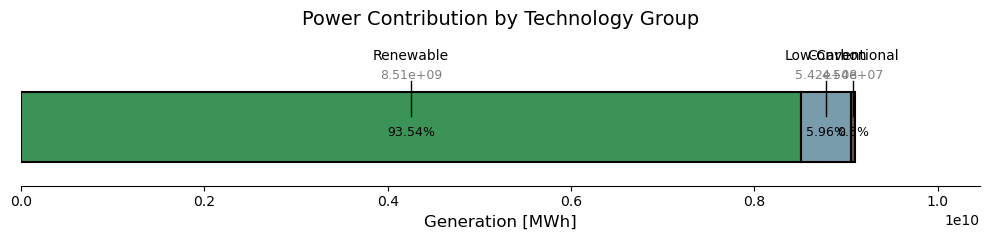

dac, no heat flex


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1078376637.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



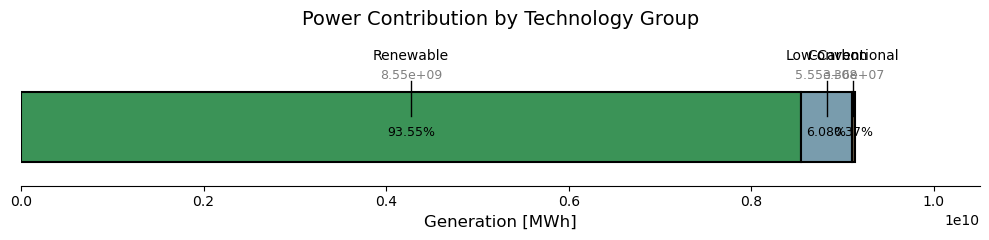

In [496]:
#2040 
print('no dac, no heat flex')
figure1 = stacked_side_bar_electric(no_dac_no_heat_flex_2040) #yeah ok it wasn't the case in the power sector, which is what we want to see
figure1
print('dac, no heat flex')
figure2 = stacked_side_bar_electric(dac_no_heat_flex_2040) #yeah ok it wasn't the case in the power sector, which is what we want to see
figure2 

no dac, no heat flex


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1078376637.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



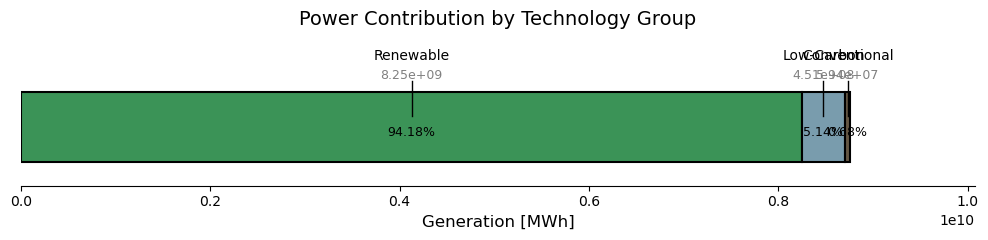

dac, no heat flex


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_48422/1078376637.py:35: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



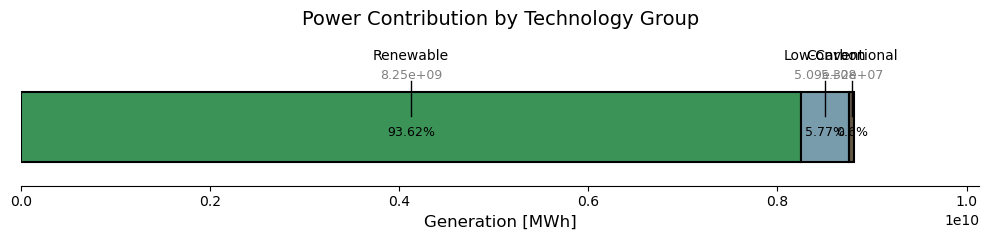

In [497]:
#2050 
print('no dac, no heat flex')
figure1 = stacked_side_bar_electric(no_dac_no_heat_flex_2050) #yeah ok it wasn't the case in the power sector, which is what we want to see
figure1
print('dac, no heat flex')
figure2 = stacked_side_bar_electric(dac_no_heat_flex_2050) #yeah ok it wasn't the case in the power sector, which is what we want to see
figure2 

Comparind the two dac heat flex runs to see if their variation is concerning 

In [338]:
print(f'network objective 1: {dac_heat_flex_2040.objective:.2e}')
print(f'network objective 2: {dac_heat_flex_2_2040.objective:.2e}')

network objective 1: 5.97e+11
network objective 2: 5.97e+11


In [339]:
print(f'total supply 1: {dac_heat_flex_2040.statistics().Supply.sum():.2e}')
print(f'total supply 2: {dac_heat_flex_2_2040.statistics().Supply.sum():.2e}')

total supply 1: 4.09e+10
total supply 2: 4.09e+10


conventional  geothermal    8.578832e+05
              nuclear       5.681880e+08
              CCGT          3.085483e+06
              OCGT          1.229243e+01
              coal          6.140411e+00
              lignite       6.383011e+00
dtype: float64
renewable  offwind-ac       1.091603e+09
           offwind-dc       1.274656e+09
           offwind-float    3.975599e+07
           onwind           2.502377e+09
           ror              1.543604e+08
           solar            2.298940e+09
           solar rooftop    1.209869e+09
           solar-hsat       1.215426e+08
dtype: float64
conventional  geothermal    8.581258e+05
              nuclear       5.681722e+08
              CCGT          3.086531e+06
              OCGT          7.045646e+00
              coal          4.029975e+00
              lignite       3.639556e+00
dtype: float64
renewable  offwind-ac       1.117112e+09
           offwind-dc       1.274438e+09
           offwind-float    3.966977e+07
           o

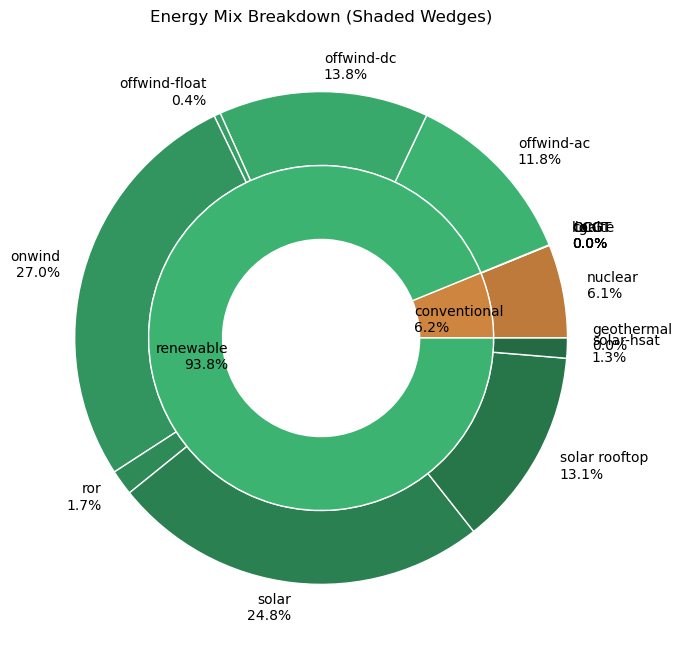

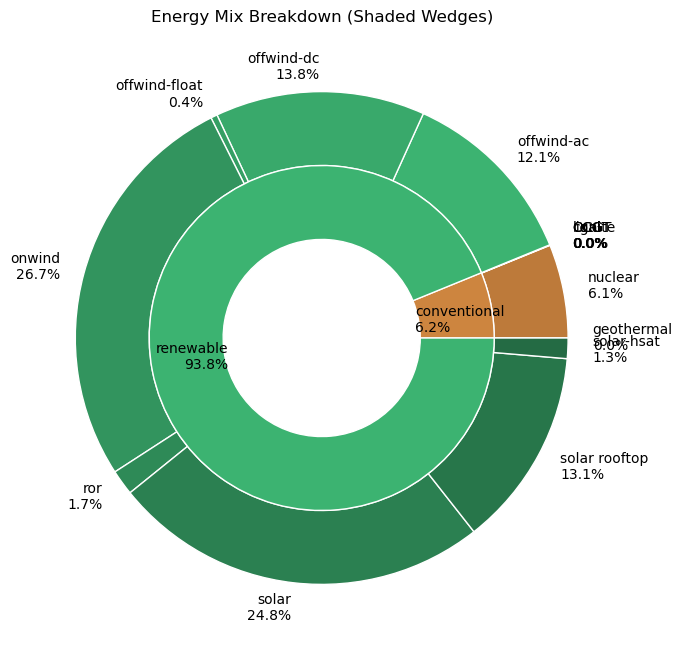

In [337]:
af.carrier_pie_chart(dac_heat_flex_2040)
af.carrier_pie_chart(dac_heat_flex_2_2040)

# What is solar rooftop connecting to and what sector is it impacting. Also where is it getting it's weather cutout? (is it the same as solar thermal?)

In [347]:
network.generators.carrier.unique()
solar_carrier = ['solar-hsat', 'solar' 'urban central solar thermal', 'rural solar thermal', 'urban decentral solar thermal', 'solar rooftop']
network.generators[network.generators.carrier.isin(solar_carrier)].tail(50)

bus  \
Generator                                                                        
PL0 0 urban decentral solar thermal collector-2040  PL0 0 urban decentral heat   
PT0 0 rural solar thermal collector-2040                      PT0 0 rural heat   
PT0 0 urban decentral solar thermal collector-2040  PT0 0 urban decentral heat   
RO0 0 rural solar thermal collector-2040                      RO0 0 rural heat   
RO0 0 urban decentral solar thermal collector-2040  RO0 0 urban decentral heat   
RS0 0 rural solar thermal collector-2040                      RS0 0 rural heat   
RS0 0 urban decentral solar thermal collector-2040  RS0 0 urban decentral heat   
SE1 0 rural solar thermal collector-2040                      SE1 0 rural heat   
SE1 0 urban decentral solar thermal collector-2040  SE1 0 urban decentral heat   
SI0 0 rural solar thermal collector-2040                      SI0 0 rural heat   
SI0 0 urban decentral solar thermal collector-2040  SI0 0 urban decentral heat   
SK0 0 rural solar thermal collector-2040                      SK0 0 rural heat   
SK0 0 urban decentral solar thermal collector-2040  SK0 0 urban decentral heat   
XK0 0 rural solar thermal collector-2040                      XK0 0 rural heat   
XK0 0 urban decentral solar thermal collector-2040  XK0 0 urban decentral heat   
AL0 0 solar-hsat-2030                                                    AL0 0   
GR0 0 solar-hsat-2030                                                    GR0 0   
PT0 0 solar-hsat-2030                                                    PT0 0   
AL0 0 solar rooftop-2030                                     AL0 0 low voltage   
AT0 0 solar rooftop-2030                                     AT0 0 low voltage   
BA0 0 solar rooftop-2030                                     BA0 0 low voltage   
BE0 0 solar rooftop-2030                                     BE0 0 low voltage   
BG0 0 solar rooftop-2030                                     BG0 0 low voltage   
CH0 0 solar rooftop-2030                                     CH0 0 low voltage   
CZ0 0 solar rooftop-2030                                     CZ0 0 low voltage   
DE0 0 solar rooftop-2030                                     DE0 0 low voltage   
ES0 0 solar rooftop-2030                                     ES0 0 low voltage   
ES6 0 solar rooftop-2030                                     ES6 0 low voltage   
FR0 0 solar rooftop-2030                                     FR0 0 low voltage   
GB2 0 solar rooftop-2030                                     GB2 0 low voltage   
GR0 0 solar rooftop-2030                                     GR0 0 low voltage   
HR0 0 solar rooftop-2030                                     HR0 0 low voltage   
HU0 0 solar rooftop-2030                                     HU0 0 low voltage   
IT0 0 solar rooftop-2030                                     IT0 0 low voltage   
IT4 0 solar rooftop-2030                                     IT4 0 low voltage   
LU0 0 solar rooftop-2030                                     LU0 0 low voltage   
ME0 0 solar rooftop-2030                                     ME0 0 low voltage   
MK0 0 solar rooftop-2030                                     MK0 0 low voltage   
NL0 0 solar rooftop-2030                                     NL0 0 low voltage   
PL0 0 solar rooftop-2030                                     PL0 0 low voltage   
PT0 0 solar rooftop-2030                                     PT0 0 low voltage   
RO0 0 solar rooftop-2030                                     RO0 0 low voltage   
RS0 0 solar rooftop-2030                                     RS0 0 low voltage   
SI0 0 solar rooftop-2030                                     SI0 0 low voltage   
SK0 0 solar rooftop-2030                                     SK0 0 low voltage   
XK0 0 solar rooftop-2030                                     XK0 0 low voltage   
ES0 0 solar-hsat-2020                                                    ES0 0   
IT0 0 solar-hsat-2020                                    

hsat solar connected to national buses 

solar thermal are connected directly to the heat buses 

solar rooftop is connected to the low voltage bus
